Future work test:
* indeed finish
* clustering
* recommand the courses based on the target location of the students
* cluster and classify the keywords finding in the dataset
* build a heirachical graph of skills by hands or models
* courses/program designed based on data scientists/analyst/engineer
* languages:, tools:, 

what the expected conclusion on the job postings:
* skills mostly wanted in the market, if possible, in different subsets(location, titles)
* the relation(frequencies in the market, dependency, ...) within the mostly wanted skills

# Data Analysis on Linkedin and Indeed

  #### <a href="#linkedin">1. Linkedin</a>
  #### &emsp; <a href="#lin1">1.1 Overall Description</a>
  #### &emsp; <a href="#lin2">1.2 Titles Analysis</a>
  #### &emsp; <a href="#lin3">1.3 Location Analysis</a>
  #### &emsp; <a href="#lin4">1.4 Keywords Extraction</a>
  #### &emsp; <a href="#lin5">1.5 Skills Analysis</a>
  #### <a href="#indeed">2. Indeed</a>
  #### <a href="#reference">3. Reference</a>

## <div id="linkedin">1. Linkedin</div>
### <div id="lin1">1.1 Overall Description</div>
Linkedin dataset was crawled with nodejs on [linked jobs](https://www.linkedin.com/jobs/).

In [1]:
import sys
import collections
import random
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
import nltk
try: nltk.data.find('tokenizers/punkt')
except LookupError: nltk.download('punkt')
try: nltk.data.find('corpora/stopwords')
except LookupError: nltk.download('stopwords')
try: nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError: nltk.download('averaged_perceptron_tagger')
try: nltk.data.find('chunkers/maxent_ne_chunker')
except LookupError: nltk.download('maxent_ne_chunker')
try: nltk.data.find('corpora/words')
except LookupError: nltk.download('words')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [0]:
fname = 'https://raw.githubusercontent.com/liuweilin17/mie1624/master/project/data/linkedin_jobs.csv'
df = pd.read_csv(fname)

In [8]:
df.head()

,Query,Location,Title,Company,Place,Link,Length,Description
0,data scientist,Canada,Data Scientist I,TD,"Markham, Ontario, Canada",https://ca.linkedin.com/jobs/view/data-scienti...,4432,TD Description Tell us your story. Don't go un...
1,data scientist,Canada,Data Scientist,RBC,"Toronto, Ontario, Canada",https://ca.linkedin.com/jobs/view/data-scienti...,5363,What is the Opportunity? We have multiple oppo...
2,data scientist,Canada,Data Scientist,Perennial Inc.,"Toronto, Ontario, Canada",https://ca.linkedin.com/jobs/view/data-scienti...,5949,"Position Title: Data Scientist, Perennial DCM ..."
3,data scientist,Canada,Lead Data Scientist (100% REMOTE ANYWHERE IN C...,GoSecure,"Montreal, Quebec, Canada",https://ca.linkedin.com/jobs/view/lead-data-sc...,4374,**** This position could be 100% remote anywhe...
4,data scientist,Canada,Junior Data Scientist,Game Hive,"Toronto, Ontario, Canada",https://ca.linkedin.com/jobs/view/junior-data-...,4748,Game Hive is building a new generation of casu...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5973 entries, 0 to 5972
Data columns (total 8 columns):
Query          5973 non-null object
Location       5973 non-null object
Title          5973 non-null object
Company        5973 non-null object
Place          5973 non-null object
Link           5973 non-null object
Length         5973 non-null int64
Description    5973 non-null object
dtypes: int64(1), object(7)
memory usage: 373.4+ KB


In [10]:
df.describe()

,Length
count,5973.000000
mean,3555.521011
std,1841.454667
min,92.000000
25%,2311.000000
50%,3366.000000
75%,4533.000000
max,21267.000000


In [11]:
for col in df.columns:
    print(col + ':')
    us = df[col].unique()
    if col != 'Description' and col != 'Link':
        print(us[:10])
    print('----------------')

Query:
['data scientist' 'data engineer' 'data analyst']
----------------
Location:
['Canada' 'United States']
----------------
Title:
['Data Scientist I' 'Data Scientist'
 'Lead Data Scientist (100% REMOTE ANYWHERE IN CANADA)'
 'Junior Data Scientist' 'Graduate Data Scientist' 'Staff data scientist'
 'Data Scientist (AI)' 'Research Data Scientist' 'Data Scientist, Manager'
 'Data Scientist - Planning Team']
----------------
Company:
['TD' 'RBC' 'Perennial Inc.' 'GoSecure' 'Game Hive' 'Rio Tinto'
 'AstraZeneca' 'Postmates Inc.' 'Shopify' 'MOJIO INC.']
----------------
Place:
['Markham, Ontario, Canada' 'Toronto, Ontario, Canada'
 'Montreal, Quebec, Canada' 'Kitimat, British Columbia, Canada' 'Canada'
 'Vancouver, British Columbia, Canada' 'Ottawa, Ontario, Canada'
 'Calgary, Alberta, Canada' 'Burnaby, British Columbia, Canada'
 'Windsor, Ontario, Canada']
----------------
Link:
----------------
Length:
[4432 5363 5949 4374 4748 4497 4999 4903 3126 3401]
----------------
Description:
--

### <div id="lin2">1.2 Titles Analysis</div>
Our datasets are the search results of **data scientist, data engineer and data analyst**. In this section, we attempt to go deep into the detailed job titles in the job postings.

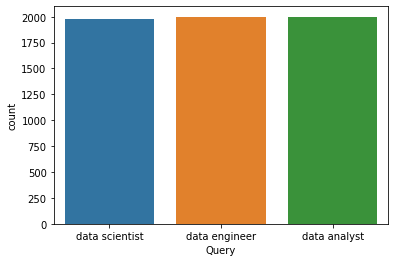

- Total number of unique titles:  1979
- Top 10 number of unique titles: 
  data scientist: 927, 15.52%
  data analyst: 911, 15.25%
  data engineer: 628, 10.51%
  senior data scientist: 70, 1.17%
  senior data analyst: 56, 0.94%
  senior data engineer: 52, 0.87%
  associate data scientist: 32, 0.54%
  business analyst: 27, 0.45%
  business data analyst: 25, 0.42%
  junior data scientist: 23, 0.39%


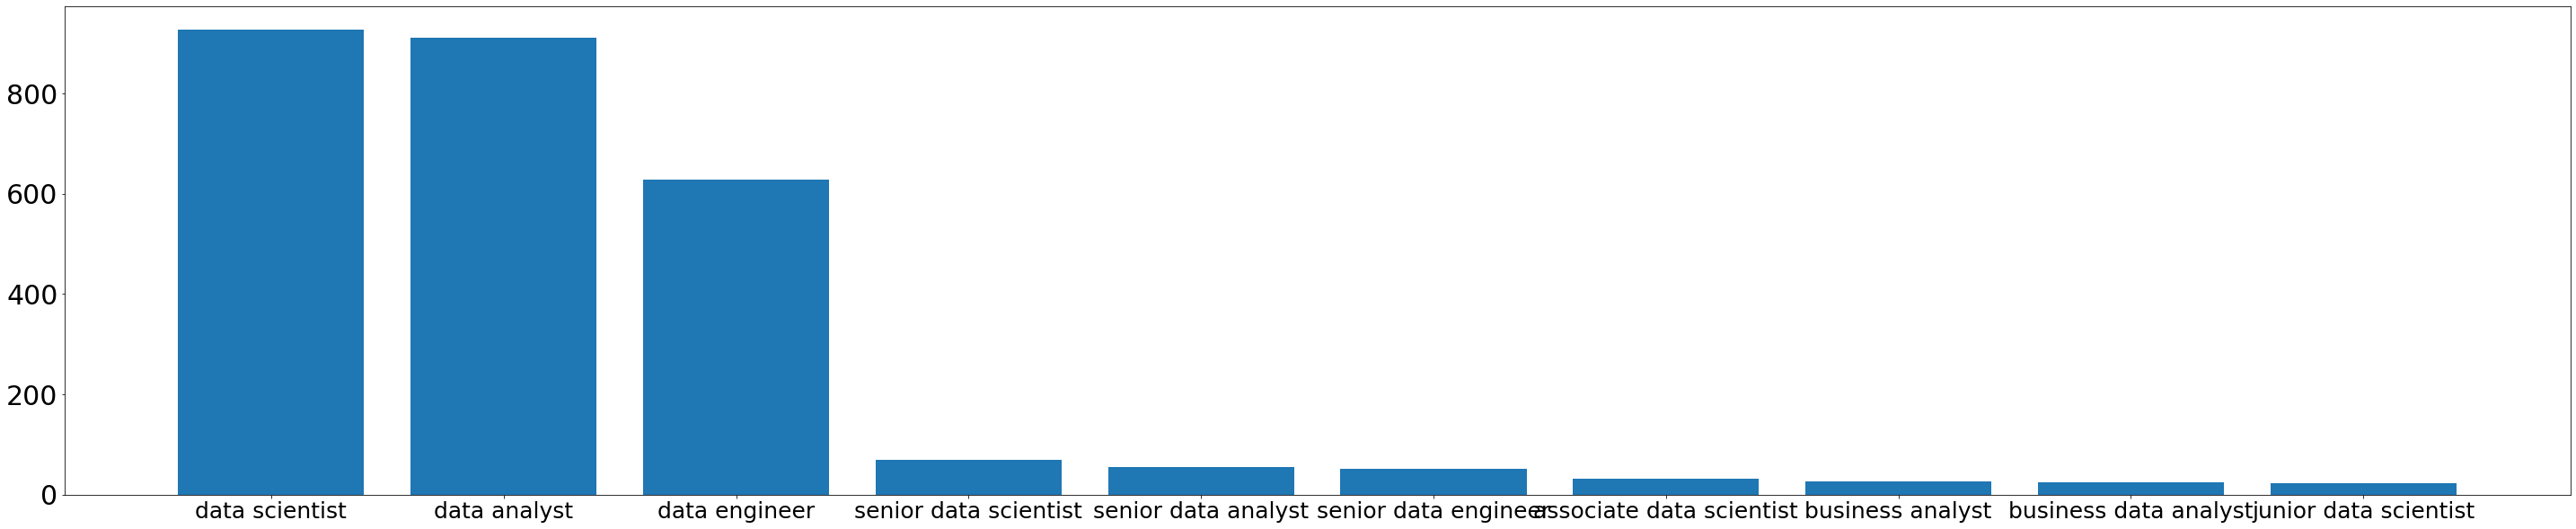

In [13]:
import re

reg_brackets = re.compile('[\(\[].*?[\)\]]')

def clean_title(title):
    title = reg_brackets.sub("", title) # remve brankets
    title = ''.join([c.lower() for c in title]) # lowercase
    title = title.strip()
    return title

def title_info(df, top=10, rms=[]):
    titles_dt = collections.Counter(df['Title'])
    for rm in rms:
        if rm in titles_dt:
            del titles_dt[rm]
    titles_sorted = sorted(titles_dt.keys(), key=lambda x:titles_dt[x], reverse=True)
    total = df.shape[0]
    print('- Total number of unique titles: ', len(titles_sorted))
    print('- Top {} number of unique titles: '.format(top))
    tops = titles_sorted[:top]
    for title in tops:
        print('  {}: {}, {}%'.format(title, titles_dt[title], format(titles_dt[title]/total*100, '.2f')))
    plt.figure(figsize=(50,10))
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=30)
    plt.bar(tops, [titles_dt[t] for t in tops])
    # plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
    plt.show()

# plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
sns.countplot(x='Query', data=df)
plt.show()
df['Title'] = df['Title'].map(clean_title)
title_info(df)
# title_info(df, rms=['data scientist', 'data analyst', 'data engineer'])

Data scientists title info: 
- Total number of unique titles:  723
- Top 10 number of unique titles: 
  senior data scientist: 40, 2.02%
  senior data analyst: 23, 1.16%
  associate data scientist: 19, 0.96%
  junior data scientist: 16, 0.81%
  data scientist i: 11, 0.56%
  data science manager: 10, 0.51%
  cloud solution architect: 10, 0.51%
  lead data scientist: 9, 0.46%
  staff data scientist: 9, 0.46%
  staff people data analyst: 8, 0.40%


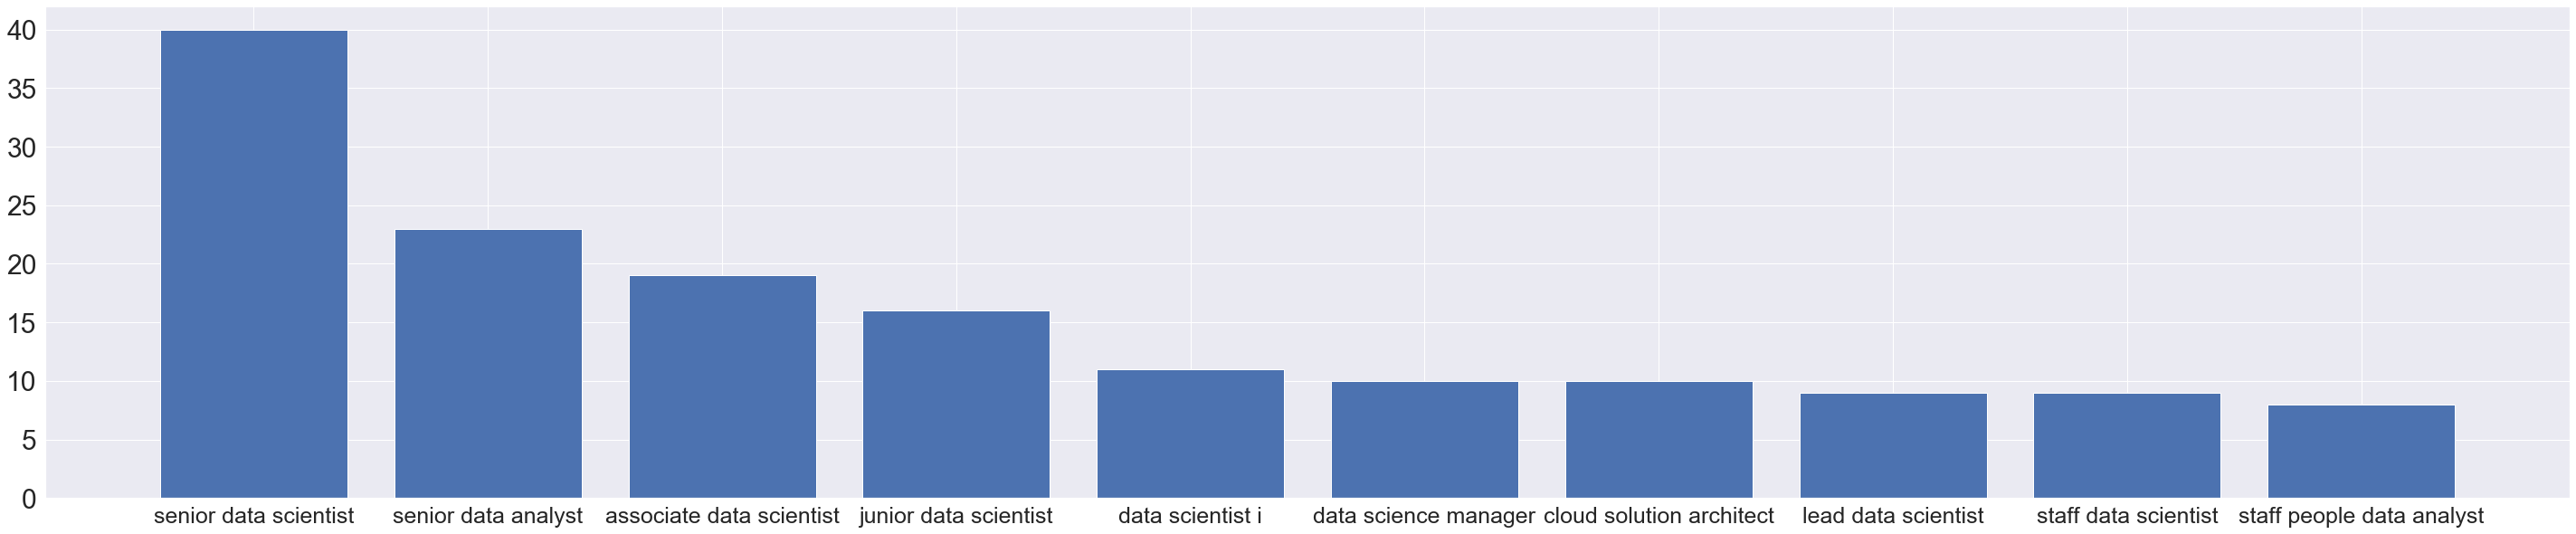

Data analyst title info: 
- Total number of unique titles:  962
- Top 10 number of unique titles: 
  senior data analyst: 33, 1.65%
  business analyst: 26, 1.30%
  business data analyst: 24, 1.20%
  analyste de données: 14, 0.70%
  data analyst i: 13, 0.65%
  business intelligence analyst: 11, 0.55%
  junior data analyst: 11, 0.55%
  data management analyst: 10, 0.50%
  data analytics analyst: 10, 0.50%
  senior business analyst: 10, 0.50%


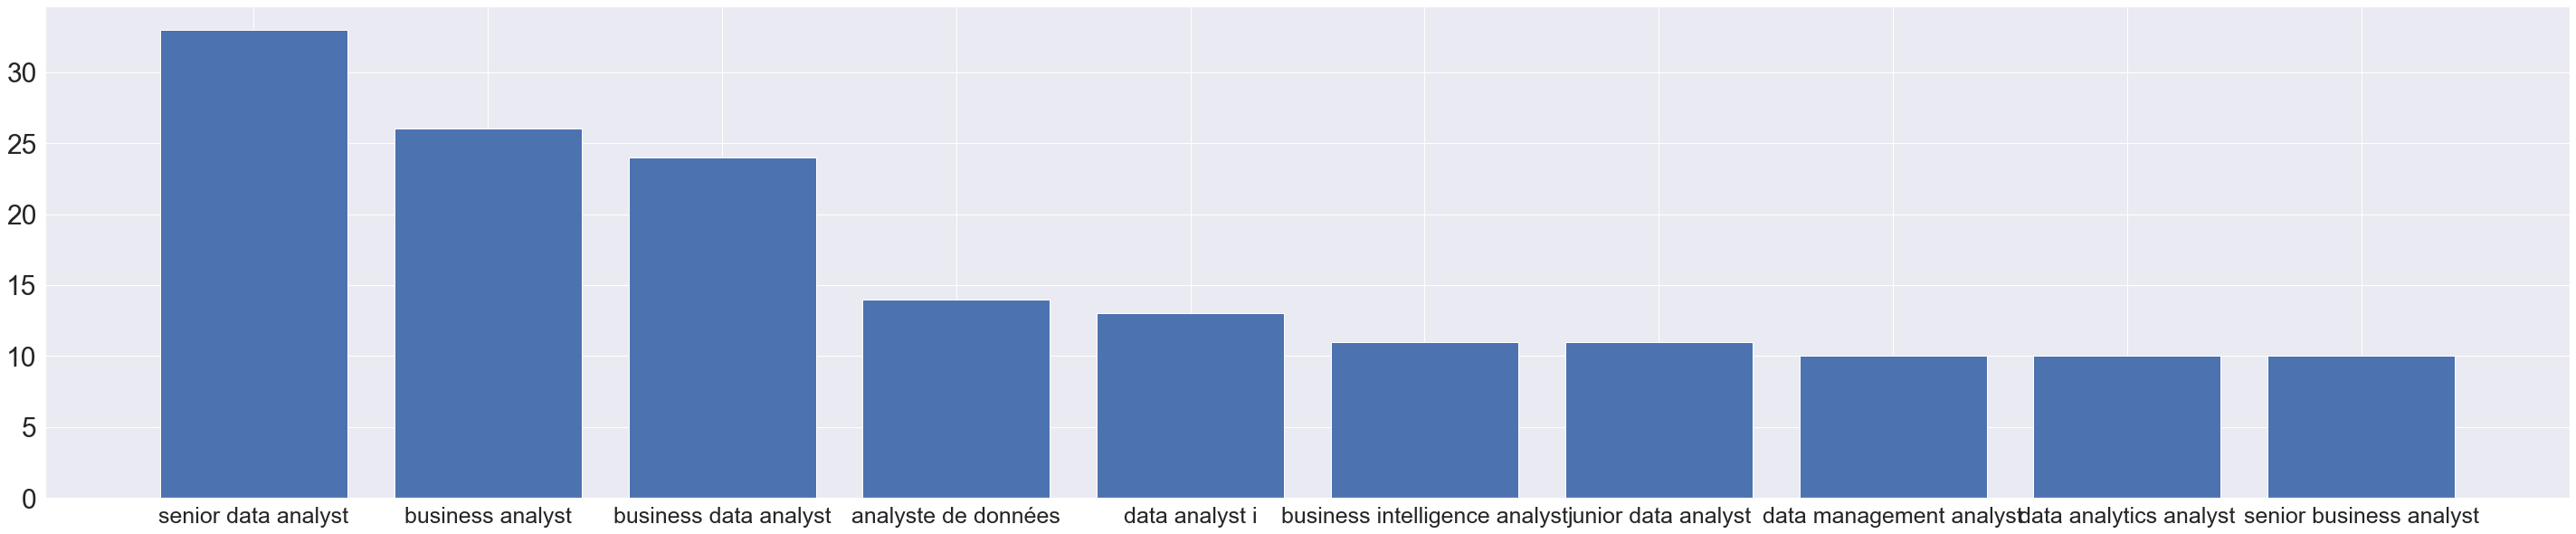

Data engineer title info: 
- Total number of unique titles:  684
- Top 10 number of unique titles: 
  senior data engineer: 49, 2.45%
  senior data scientist: 30, 1.50%
  lead data engineer: 13, 0.65%
  associate data scientist: 13, 0.65%
  cloud consultant - canada: 11, 0.55%
  database engineer: 9, 0.45%
  cloud consultant: 9, 0.45%
  software engineer: 8, 0.40%
  devops engineer: 8, 0.40%
  data integration engineer: 8, 0.40%


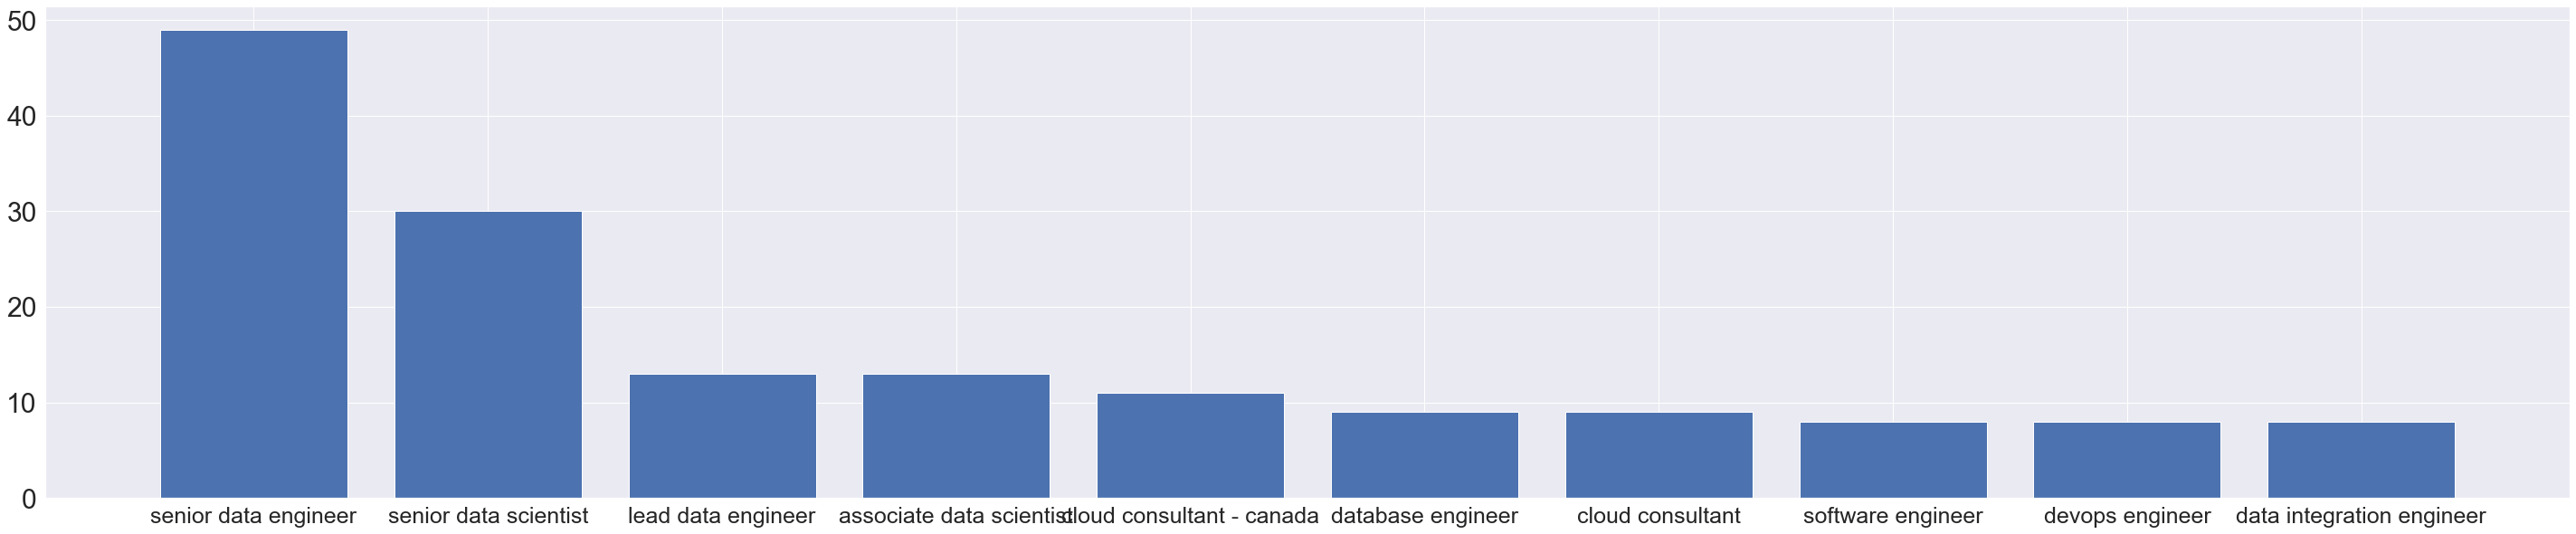

In [0]:
rms=['data scientist', 'data analyst', 'data engineer']
df_scientist = df[df['Query']=='data scientist']
df_analyst = df[df['Query']=='data analyst']
df_engineer = df[df['Query']=='data engineer']
print('Data scientists title info: ')
title_info(df_scientist, rms=rms)
print('Data analyst title info: ')
title_info(df_analyst, rms=rms)
print('Data engineer title info: ')
title_info(df_engineer, rms=rms)

We found that **'Senior' or 'Lead'** positions are mostly wanted in the job market for data scientist, data analyst, data engineer. In the same time, for **data analyst**, the job title frequently contains **business**, which indicates having a background of business could make the candiates be more competitive. For **data engineer**, the jobs titles contains lots of words related to **software engineering**, such as database, cloud, software, devops, etc. People with background of both data and software engineering could be more equal to data engineer positions.

### <div id="lin3">1.3 Location Analysis</div>
The location of the jobs are in **Canada** and **United States**. In this section, we attempt to analyze the impact of locations.

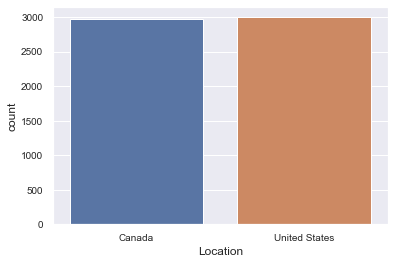

- Total number of unique places:  679
- Top 8 places: 
  toronto,ontario,CA: 1001, 16.76%
  montreal,quebec,CA: 444, 7.43%
  vancouver,british columbia,CA: 385, 6.45%
  new york,new york,UN: 263, 4.40%
  san francisco,california,UN: 176, 2.95%
  ottawa,ontario,CA: 128, 2.14%
  other, other, CA: 123, 2.06%
  calgary,alberta,CA: 118, 1.98%


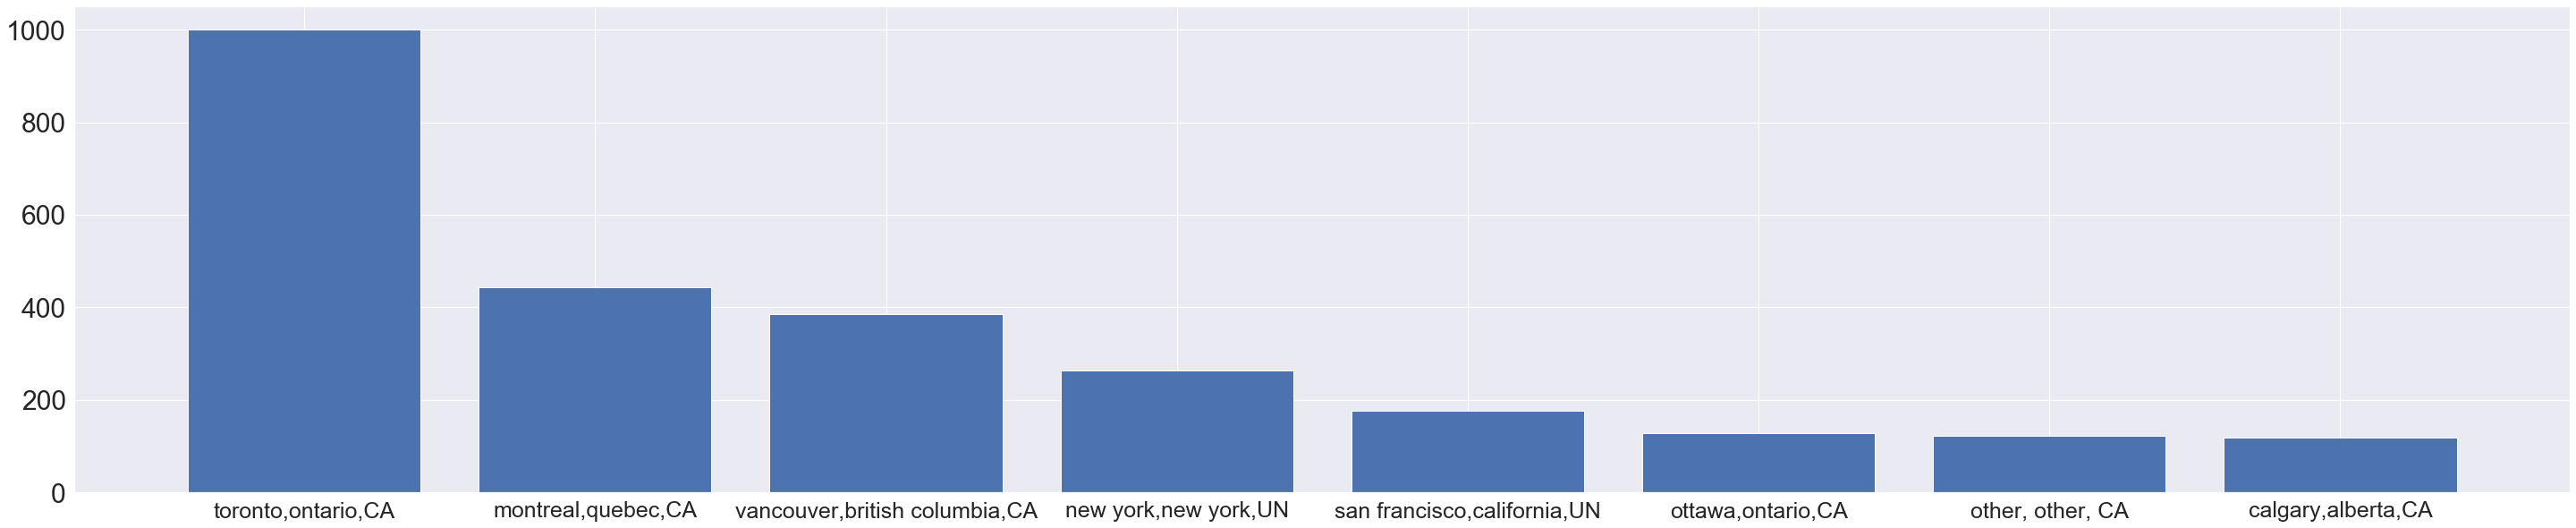

In [0]:
def clean_place(place):
    countries = ['canada', 'united states']
    place_lst = place.split(',')
    place_lst = [place.strip() for place in place_lst]
    place = ','.join(place_lst)
    place = ''.join([c.lower() for c in place]) # lowercase
    place = place.strip()
    return place

def format_place(place):
    if place == 'canada' or place == 'united states':
        place = 'other, other, ' + place
    place = re.sub("canada", "CA", place)
    place = re.sub("united states", "UN", place)
    return place

def place_info(df, top=10, rms=[]):
    places_dt = collections.Counter(df['Place'])

    for rm in rms:
        if rm in places_dt:
            del places_dt[rm]
    places_sorted = sorted(places_dt.keys(), key=lambda x:places_dt[x], reverse=True)
    total = df.shape[0]
    print('- Total number of unique places: ', len(places_sorted))
    print('- Top {} places: '.format(top))
    tops = places_sorted[:top]
    for place in tops:
        print('  {}: {}, {}%'.format(place, places_dt[place], format(places_dt[place]/total*100, '.2f')))
    plt.figure(figsize=(50,10))
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=30)
    plt.bar(tops, [places_dt[t] for t in tops])
    plt.show()

# plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
sns.countplot(x='Location', data=df)
plt.show()

df['Place'] = df['Place'].map(clean_place)
df['Place'] = df['Place'].map(format_place)
place_info(df, top=8)

Canada info: 
- Total number of unique places:  110
- Top 8 places: 
  toronto,ontario,CA: 1001, 33.65%
  montreal,quebec,CA: 444, 14.92%
  vancouver,british columbia,CA: 385, 12.94%
  ottawa,ontario,CA: 128, 4.30%
  calgary,alberta,CA: 118, 3.97%
  brampton,ontario,CA: 57, 1.92%
  edmonton,alberta,CA: 54, 1.82%
  waterloo,ontario,CA: 54, 1.82%


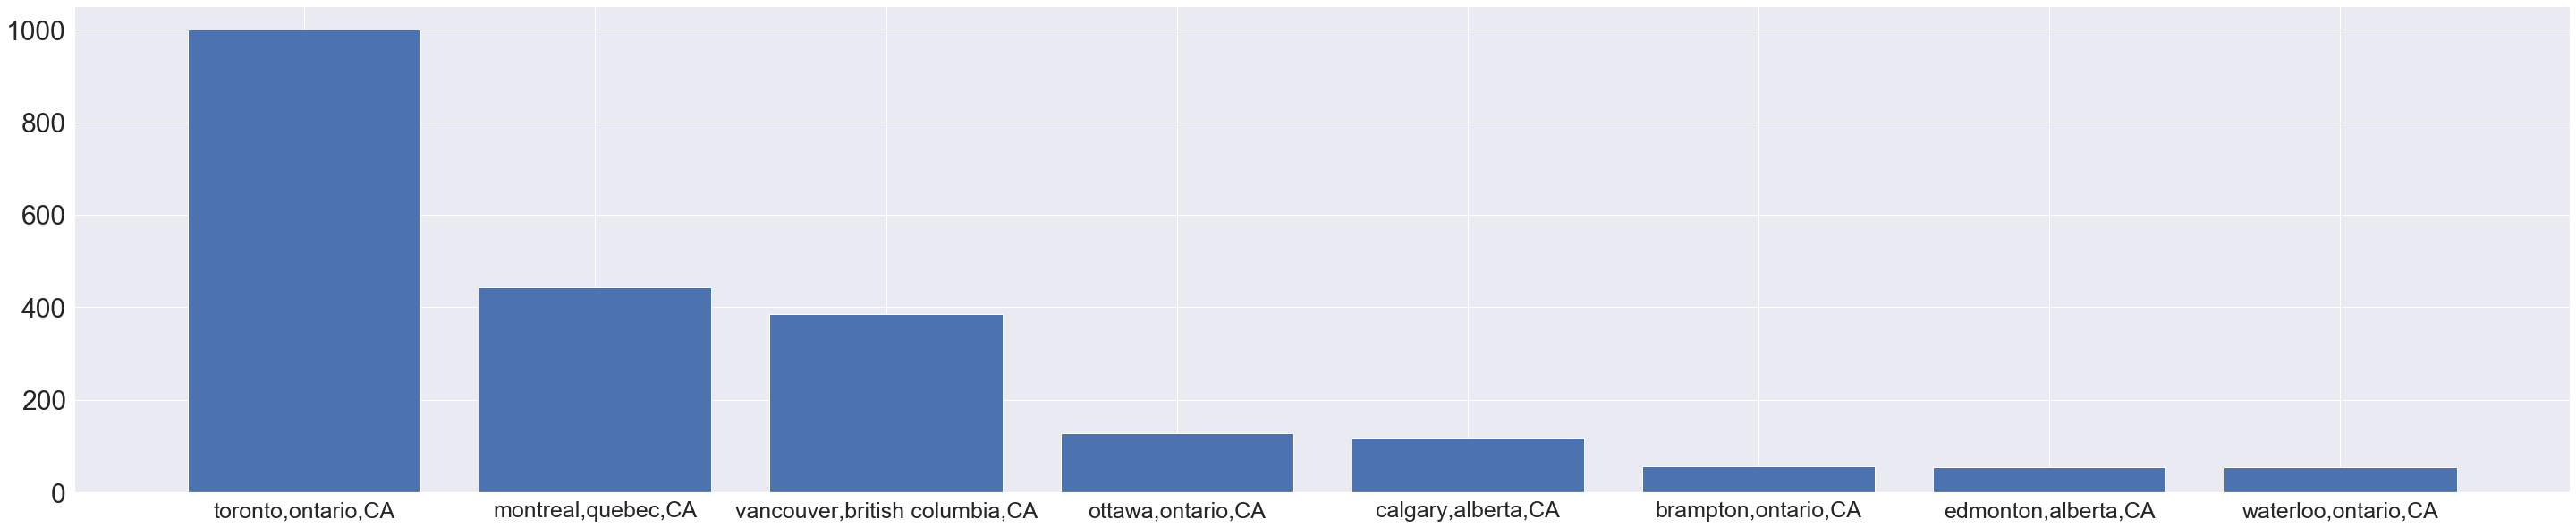

United States info: 
- Total number of unique places:  567
- Top 8 places: 
  new york,new york,UN: 263, 8.77%
  san francisco,california,UN: 176, 5.87%
  chicago,illinois,UN: 84, 2.80%
  washington,district of columbia,UN: 70, 2.33%
  atlanta,georgia,UN: 69, 2.30%
  greater boston: 58, 1.93%
  seattle,washington,UN: 57, 1.90%
  houston,texas,UN: 52, 1.73%


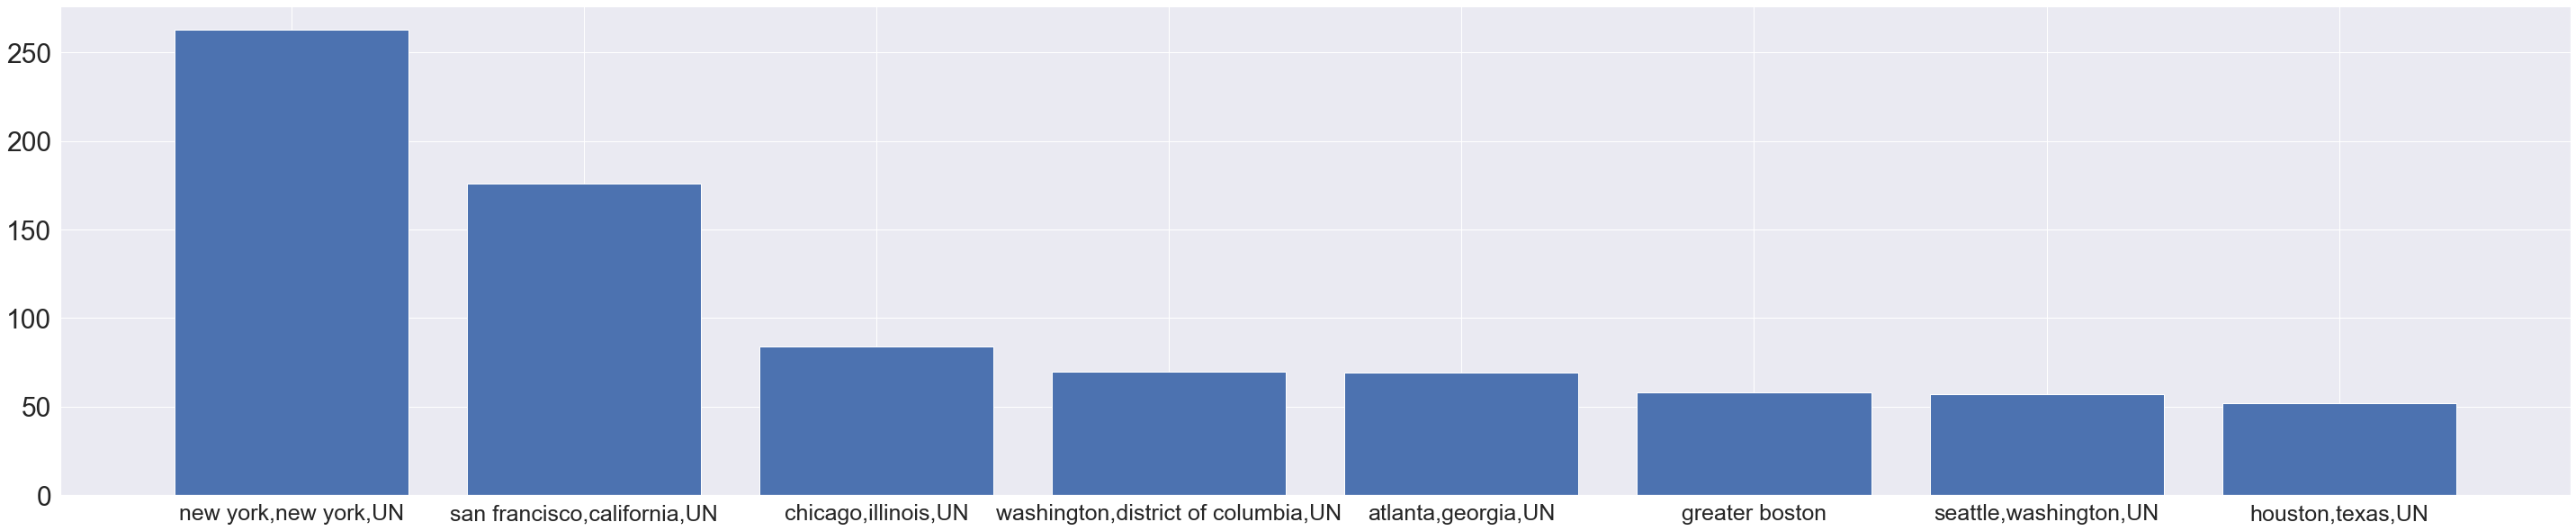

In [0]:
rms=['other, other, CA', 'other, other, UN']
df_ca = df[df['Location']=='Canada']
df_un = df[df['Location']=='United States']

print('Canada info: ')
place_info(df_ca, top=8, rms=rms)
print('United States info: ')
place_info(df_un, top=8, rms=rms)

Among all cities in both Canada and United States, **Toronto** tend to have the highest number of positions related to data science. In Canada, **Toronto, Montreal, Vancouver, Ottowa and Cagary** are the top 5 cities wanted for employees in data science. In United States, **New York, San Francisco, Chicago, Washington and Atlanta** are the top 5 cities wanted for employees in data science.

### <div id="lin4">1.4 Keywords Extraction</div>
Our datasets also contains the descriptions of the jobs. In this section, we attempt to extract some keywords from these job descriptions

In [0]:
def select(countries, titles):
    # select rows given countries and titles
    df_new = df[(df.Query.isin(titles)) & (df.Location.isin(countries))]
    return df_new

def basic_analysis(df):
    # number of words
    raw = ' '.join(df_new['Description'])
    print('raw words number: ', len(raw))
    
    # tokenize: break up the string into words and punctuation by
    # removing whitespace, line breaks, blank lines
    tokens = nltk.word_tokenize(raw)
    words = [w.lower() for w in tokens]
    print('tokens number: ', len(words))
    
    # set tokens back to Text for further analyze
    text = nltk.Text(words)
    # Frequent bigrams
    # print('Frquenct bigrams: ', text.collocations())
    
    # number of vocabulary
    voc = set(words)
    print('vocabulary size: ', len(voc))
    
    # frequency distribution
    fdist = nltk.FreqDist(text)
    print(fdist)
    print(fdist.most_common(10))
    # plot the frequency distribution
    display(fdist.plot())
    display(fdist.plot(cumulative=True))
    
def chunk1(sent):
    # https://www.nltk.org/book/ch07.html
    entities = []
    sent = nltk.pos_tag(sent)
    nes = nltk.ne_chunk(sent)
    for ne in nes:
        if type(ne) is not tuple:
            tmp = ' '.join([w for w, t in ne.leaves()])
            entities.append(tmp)
    return entities

from rake_nltk import Rake
r = Rake()
def chunk2(sent):
    # https://www.github.com/csurfer/rake-nltk
    sent = ' '.join(sent)
    r.extract_keywords_from_text(sent)
    return r.get_ranked_phrases()
    
def analyze(df, chunk_tag):
    entities_count = collections.defaultdict(int)
    for sentences in df['Description']:
#         sentences = nltk.sent_tokenize(raw)
#         sentences = [nltk.word_tokenize(sent) for sent in sentences]
        for sent in sentences:
            if chunk_tag == 1:
                entities = chunk1(sent)
            elif chunk_tag == 2:
                entities = chunk2(sent)
            else:
                pass
            if not entities:
                continue
            for en in entities:
                if en not in stop_words:
                    entities_count[en] += 1
    
    sorted_entities = sorted(entities_count.keys(), key=lambda x:entities_count[x], reverse=True)
    print([(en, entities_count[en]) for en in sorted_entities[:50]])
    return entities_count

# word cloud
def draw_cloud(entities_count):
    s = []
    for en, cnt in entities_count.items():
        s += [en for _ in range(cnt)]
    random.shuffle(s)
    wcloud = WordCloud(background_color='white',
                          stopwords=[],
                          max_words=100,
                          max_font_size=50,
                          random_state=42,
                        ).generate(','.join(s))
    plt.figure(figsize=(100,100))
    plt.imshow(wcloud)
    plt.axis('off')
    plt.show()
    
def tokenize_description(description):
    sentences = nltk.sent_tokenize(description)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    return sentences

Descripion Tokenize Done.
Canada , data scientist :  (978, 8)
[('Python', 593), ('SQL', 529), ('Experience', 390), ('Computer Science', 356), ('Spark', 256), ('AWS', 246), ('Data Science', 232), ('Tableau', 216), ('Hadoop', 211), ('Develop', 202), ('Work', 197), ('Data Analyst', 188), ('Toronto', 179), ('Data Scientist', 174), ('Statistics', 174), ('Microsoft', 173), ('ETL', 171), ('Java', 155), ('R', 150), ('Scala', 135), ('AI', 132), ('Mathematics', 132), ('Geotab', 131), ('Azure', 130), ('Excel', 130), ('Build', 119), ('Machine Learning', 119), ('Analytics', 118), ('SAS', 113), ('NLP', 113), ('Amazon', 97), ('Mozilla', 96), ('Business', 93), ('Hive', 92), ('English', 88), ('Nous', 85), ('NoSQL', 82), ('Analyze', 81), ('API', 80), ('Oracle', 78), ('University', 77), ('Canadian', 76), ('Perform', 74), ('SAP', 73), ('School', 73), ('Skills', 72), ('Participate', 71), ('Expérience', 71), ('IBM', 70), ('Identify', 70)]


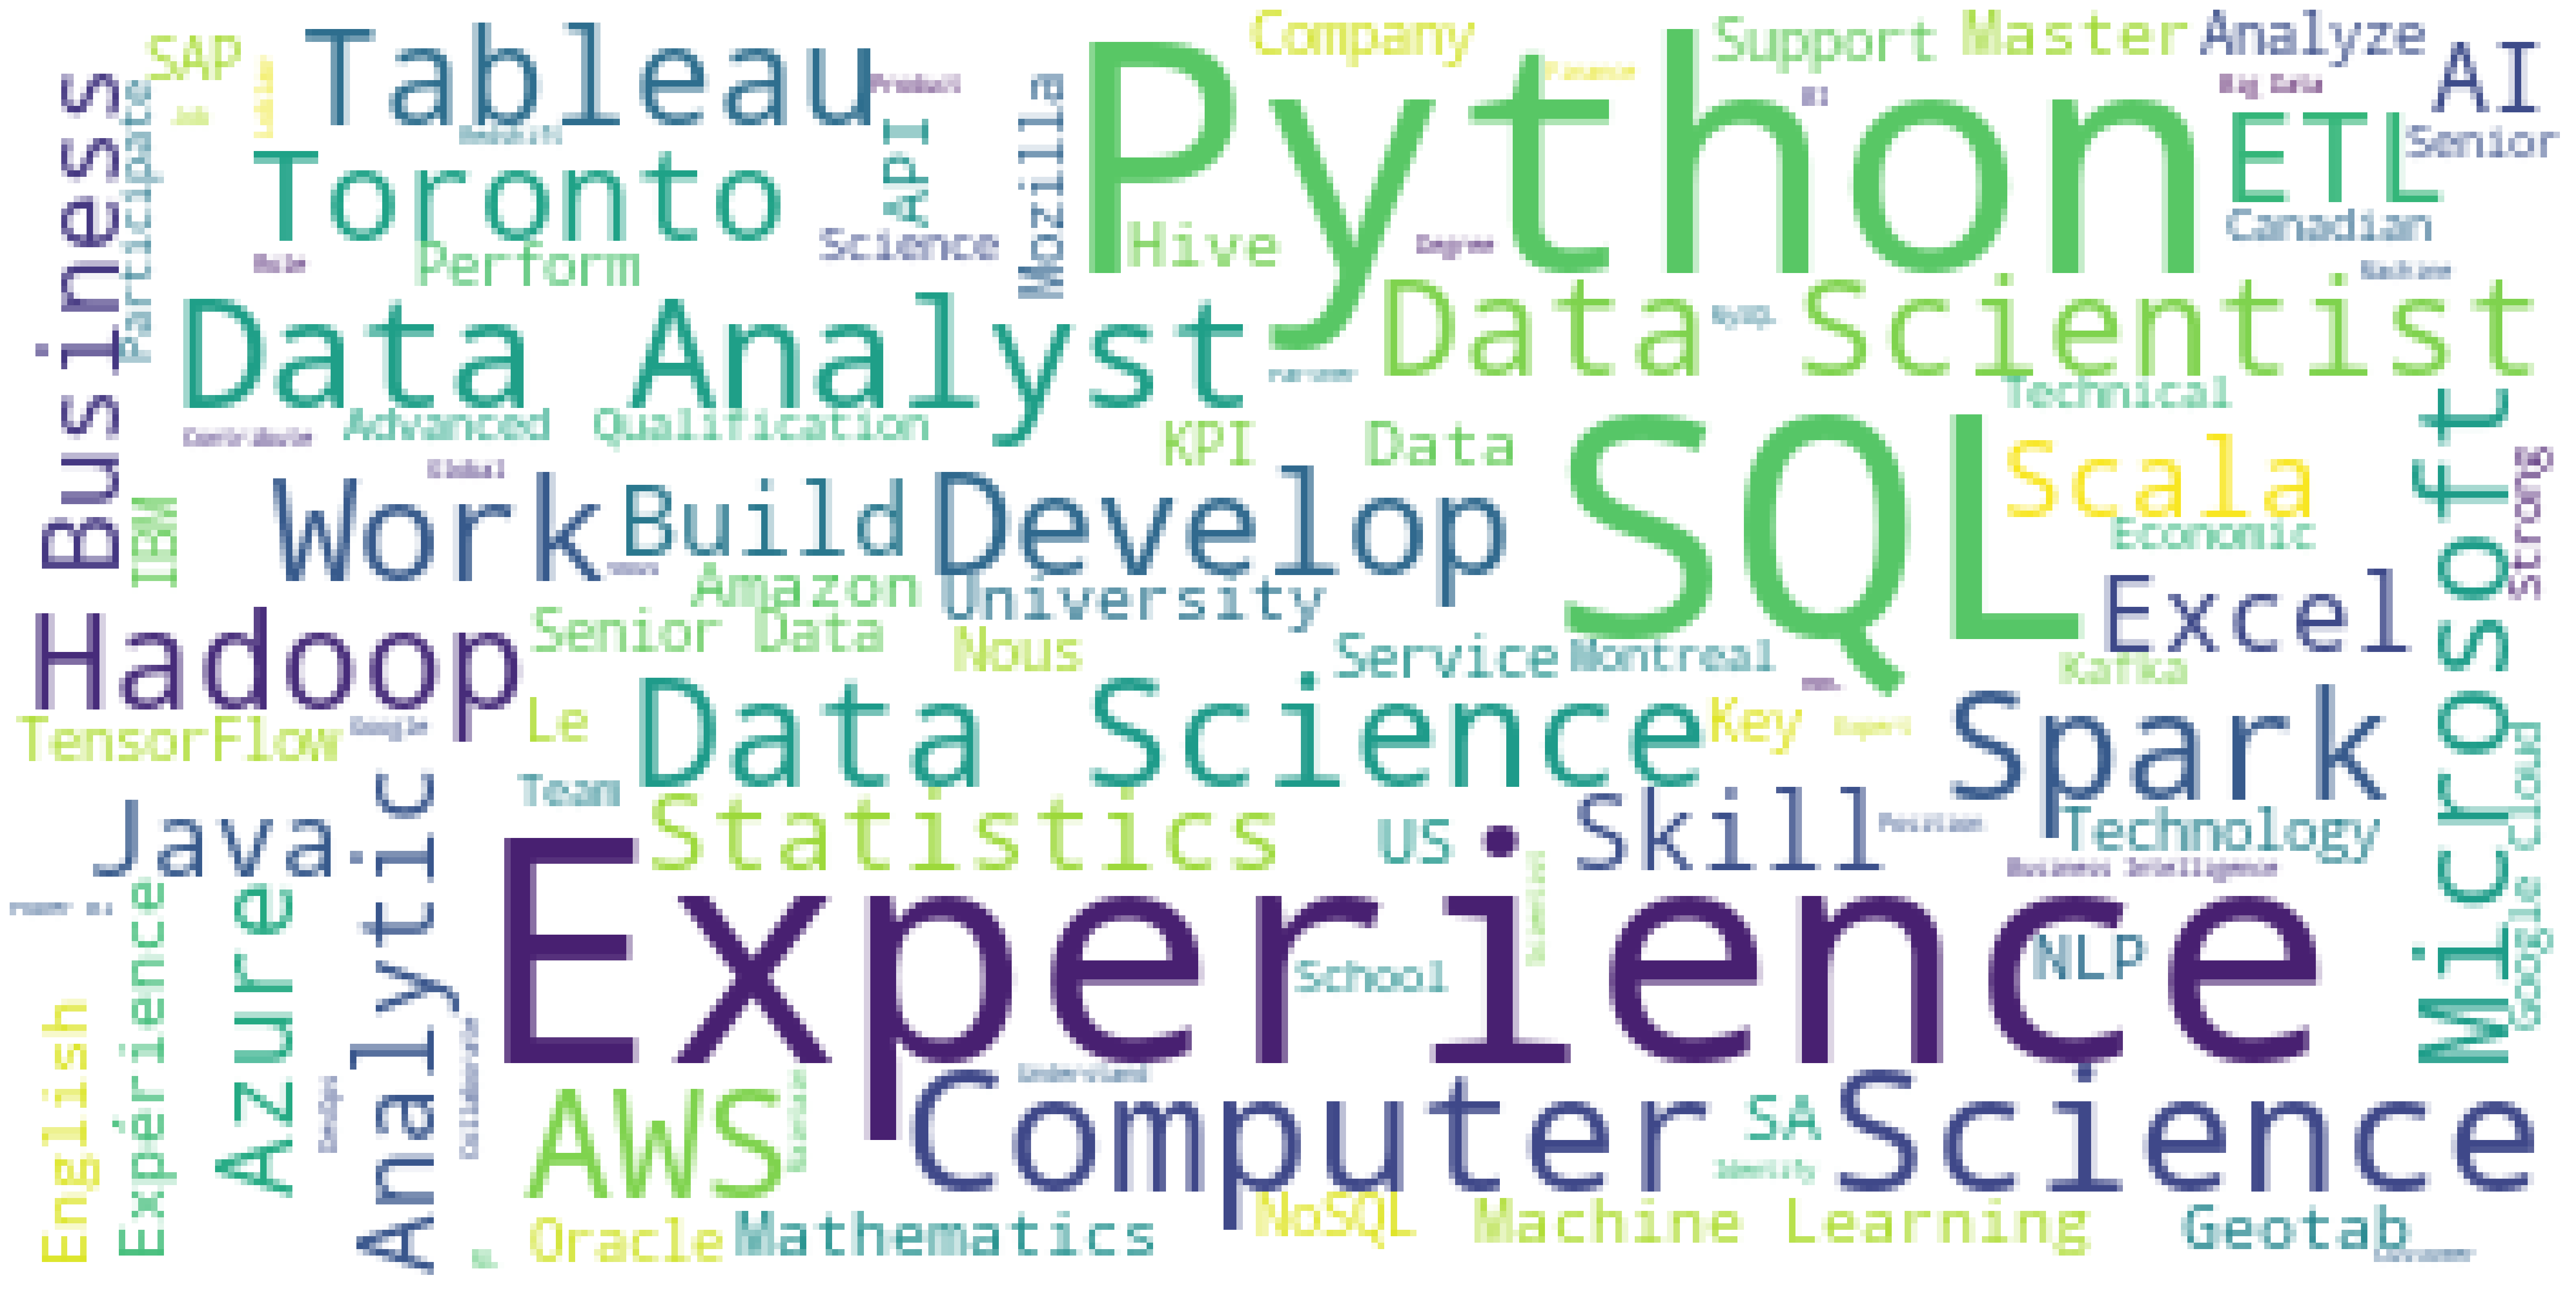

Canada , data engineer :  (997, 8)
[('Python', 729), ('Experience', 658), ('SQL', 450), ('Computer Science', 420), ('AWS', 368), ('Java', 362), ('Spark', 310), ('ETL', 260), ('Hadoop', 243), ('Microsoft', 231), ('Work', 214), ('Develop', 213), ('Azure', 204), ('Scala', 174), ('Data Engineer', 166), ('Toronto', 156), ('Cloud', 152), ('Data Science', 149), ('Amazon', 138), ('Google', 130), ('Pythian', 130), ('GCP', 128), ('AI', 127), ('Machine Learning', 125), ('Build', 125), ('Kafka', 124), ('Canadian', 122), ('R', 119), ('NoSQL', 117), ('Data Scientist', 116), ('DevOps', 114), ('Tableau', 111), ('Oracle', 111), ('Linux', 111), ('APIs', 111), ('Docker', 104), ('Elastic', 104), ('Kubernetes', 102), ('JavaScript', 99), ('Key', 96), ('Statistics', 96), ('Analytics', 96), ('Microsoft Azure', 96), ('IBM', 94), ('Solid', 93), ('Company', 92), ('API', 90), ('MySQL', 89), ('Mathematics', 88), ('Hive', 87)]


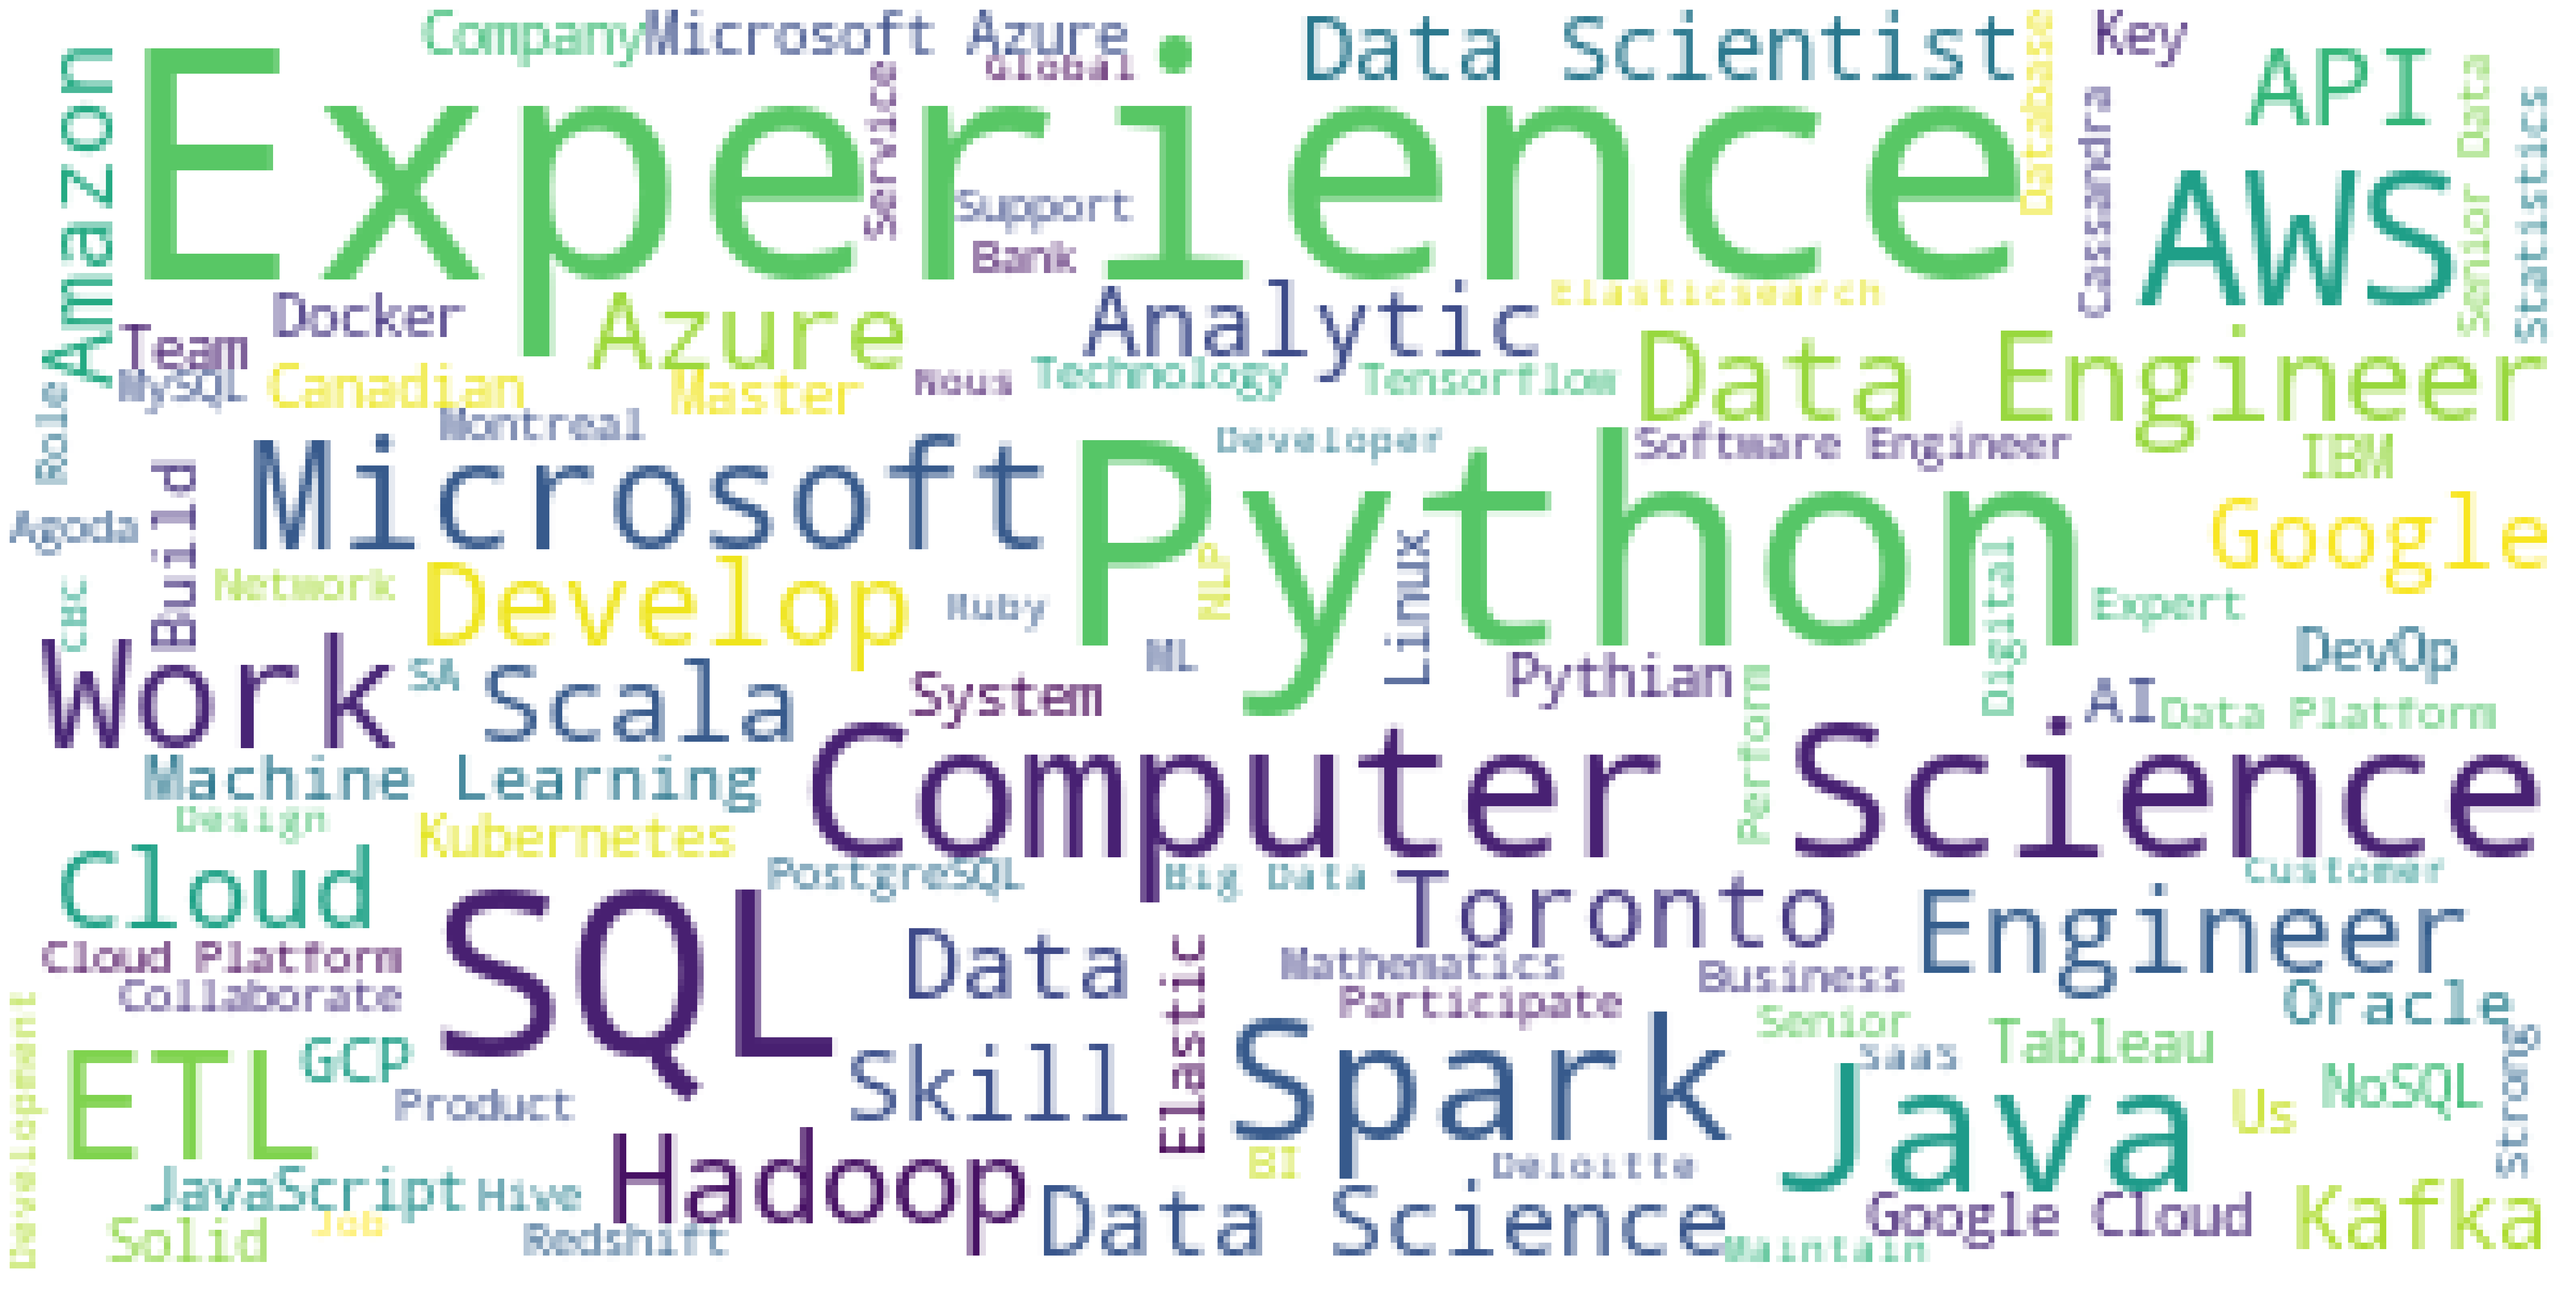

Canada , data analyst :  (1000, 8)
[('SQL', 441), ('Experience', 392), ('Excel', 260), ('Tableau', 254), ('Develop', 243), ('Python', 210), ('SAP', 197), ('Business', 195), ('Computer Science', 191), ('Data Analyst', 186), ('Work', 185), ('Canadian', 163), ('Toronto', 154), ('ETL', 153), ('Finance', 140), ('Analyze', 127), ('Microsoft', 122), ('Identify', 119), ('Assist', 117), ('SAS', 112), ('Support', 111), ('Business Analyst', 107), ('Provide', 106), ('English', 103), ('Power BI', 98), ('Perform', 96), ('Build', 94), ('ERP', 92), ('KPIs', 91), ('Key', 90), ('PowerPoint', 90), ('Analytics', 88), ('French', 87), ('Analyst', 85), ('Company', 85), ('CRM', 84), ('University', 81), ('Ensure', 81), ('Skills', 80), ('Conduct', 78), ('AWS', 78), ('Word', 77), ('R', 73), ('Maintain', 72), ('Mathematics', 70), ('Business Intelligence', 70), ('Nous', 70), ('Statistics', 69), ('BI', 69), ('North America', 67)]


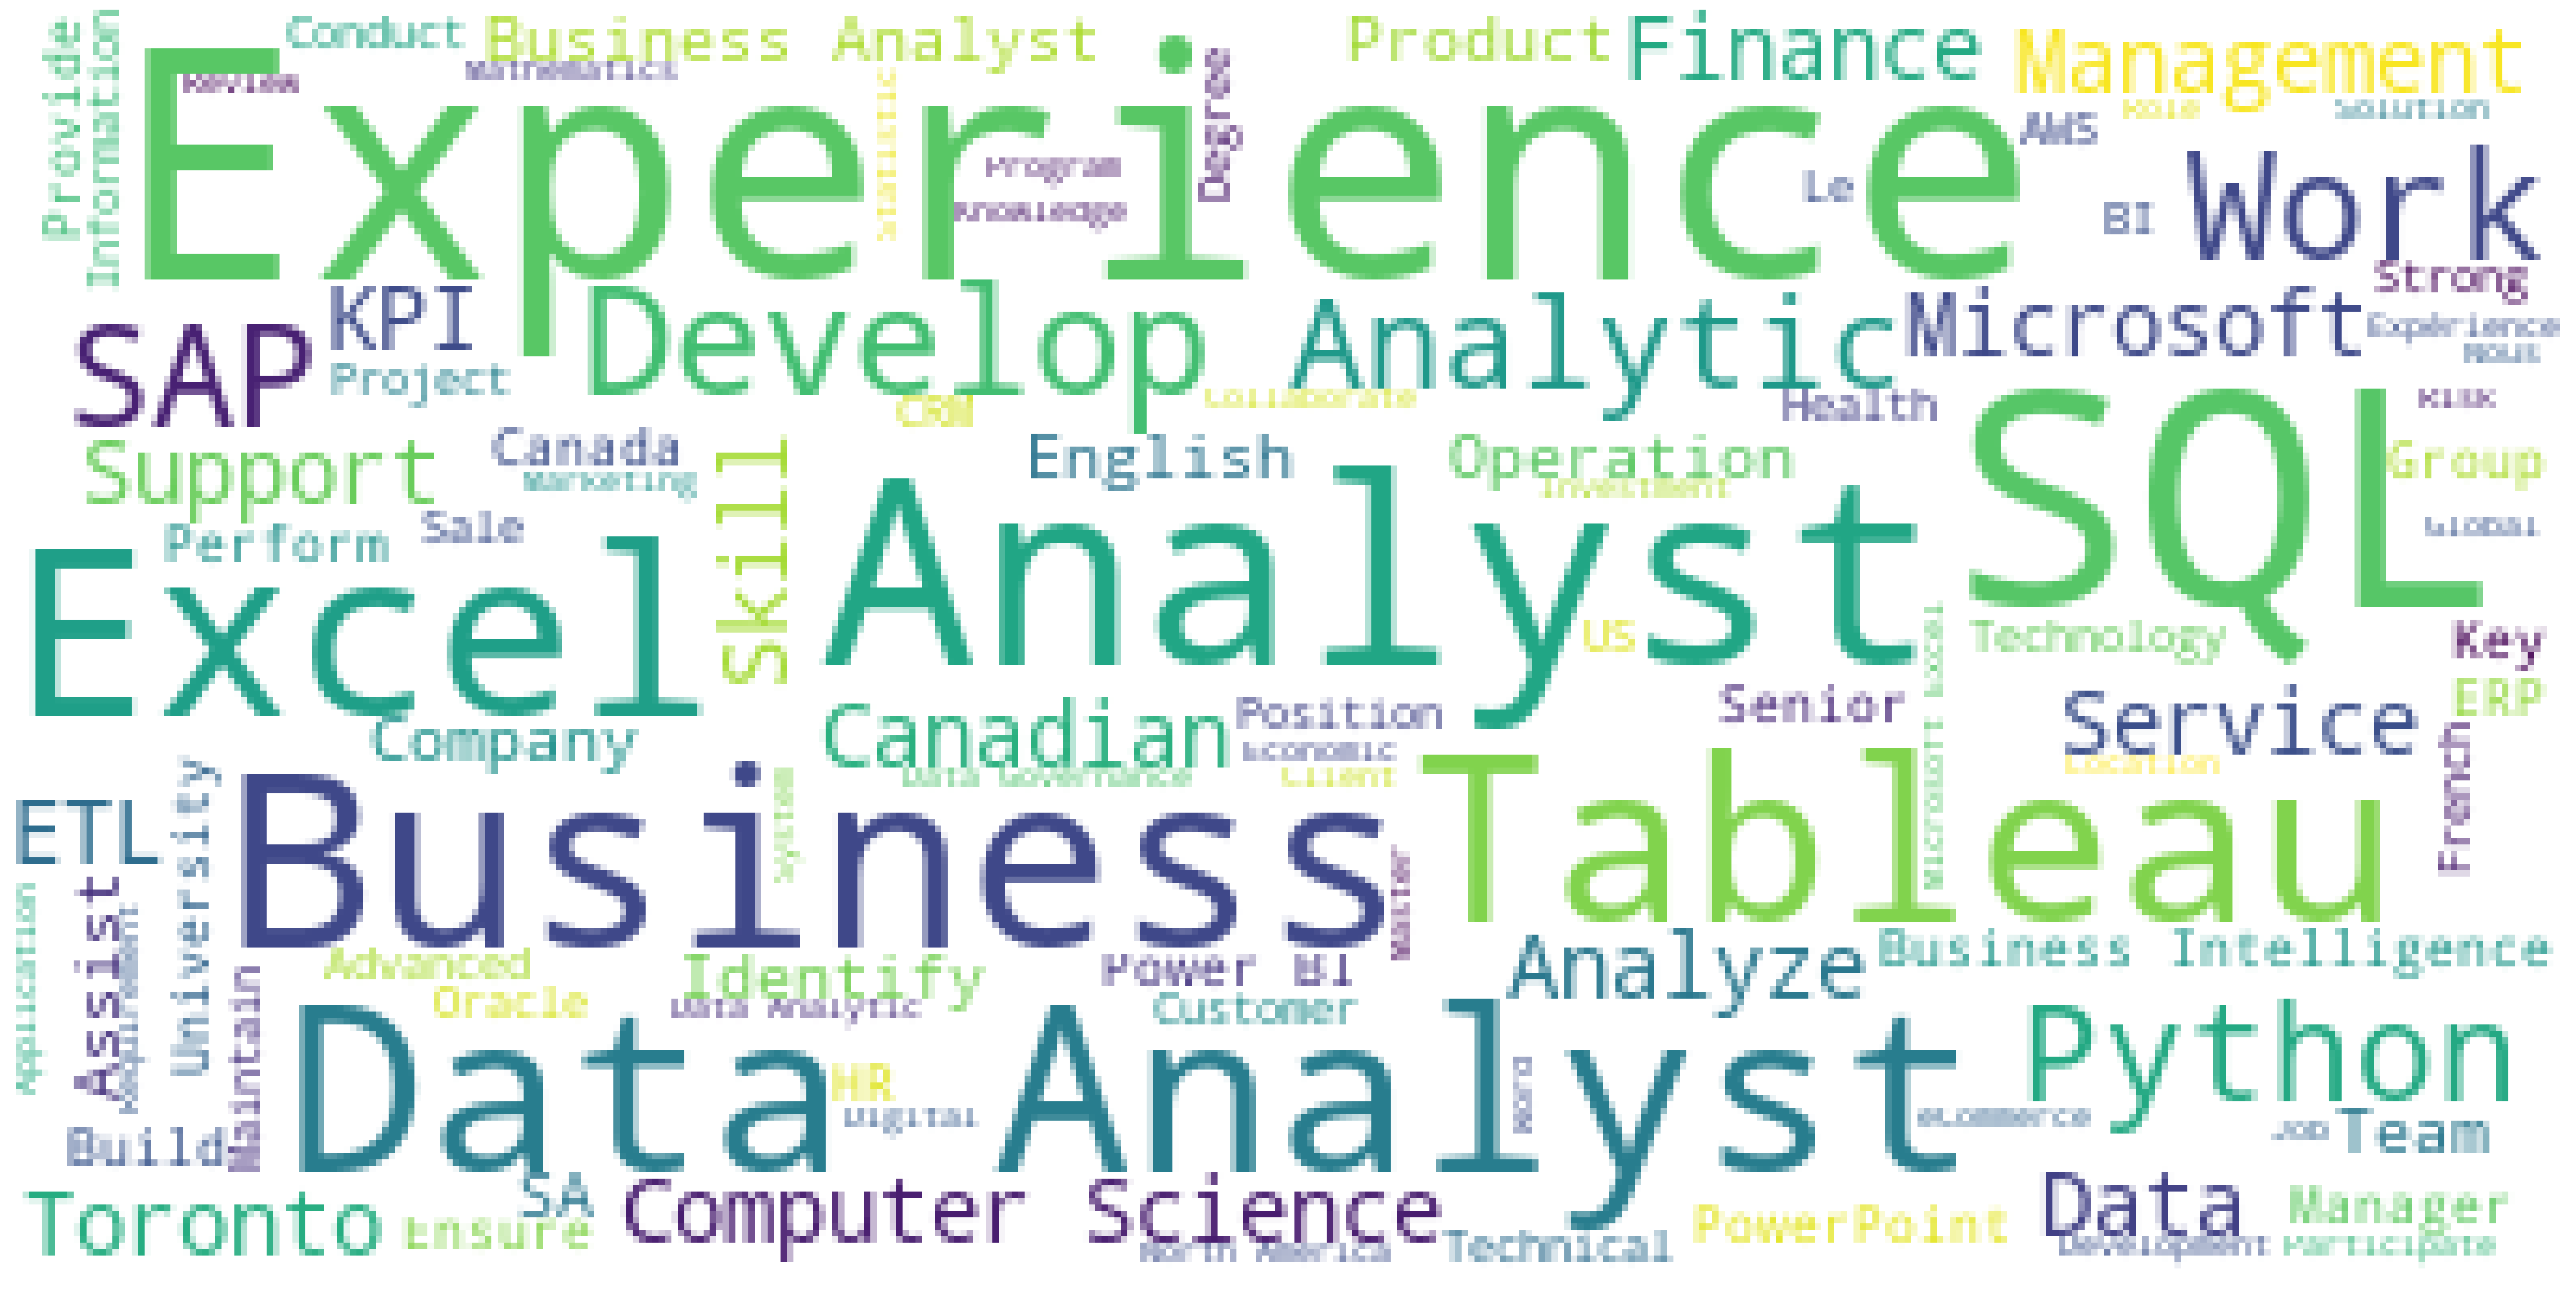

United States , data scientist :  (999, 8)
[('Python', 794), ('SQL', 613), ('Experience', 594), ('R', 359), ('Data Scientist', 354), ('Computer Science', 333), ('Data Science', 283), ('Tableau', 275), ('Develop', 252), ('Statistics', 237), ('SAS', 205), ('Data Analyst', 197), ('Work', 184), ('Spark', 174), ('Mathematics', 163), ('Hadoop', 155), ('Machine Learning', 152), ('Master', 136), ('Java', 129), ('Excel', 116), ('NLP', 113), ('U.S.', 110), ('AWS', 108), ('Analytics', 106), ('Build', 105), ('Degree', 102), ('United States', 99), ('Skills', 97), ('US', 93), ('Perform', 89), ('ETL', 87), ('Partner', 87), ('Company', 87), ('Economics', 86), ('Identify', 83), ('Scala', 78), ('Business', 78), ('Collaborate', 77), ('AI', 75), ('Analyze', 73), ('Hive', 71), ('Operations Research', 68), ('Physics', 68), ('Communicate', 67), ('Key', 66), ('Apply', 64), ('Provide', 64), ('Position', 62), ('Product', 59), ('Power BI', 59)]


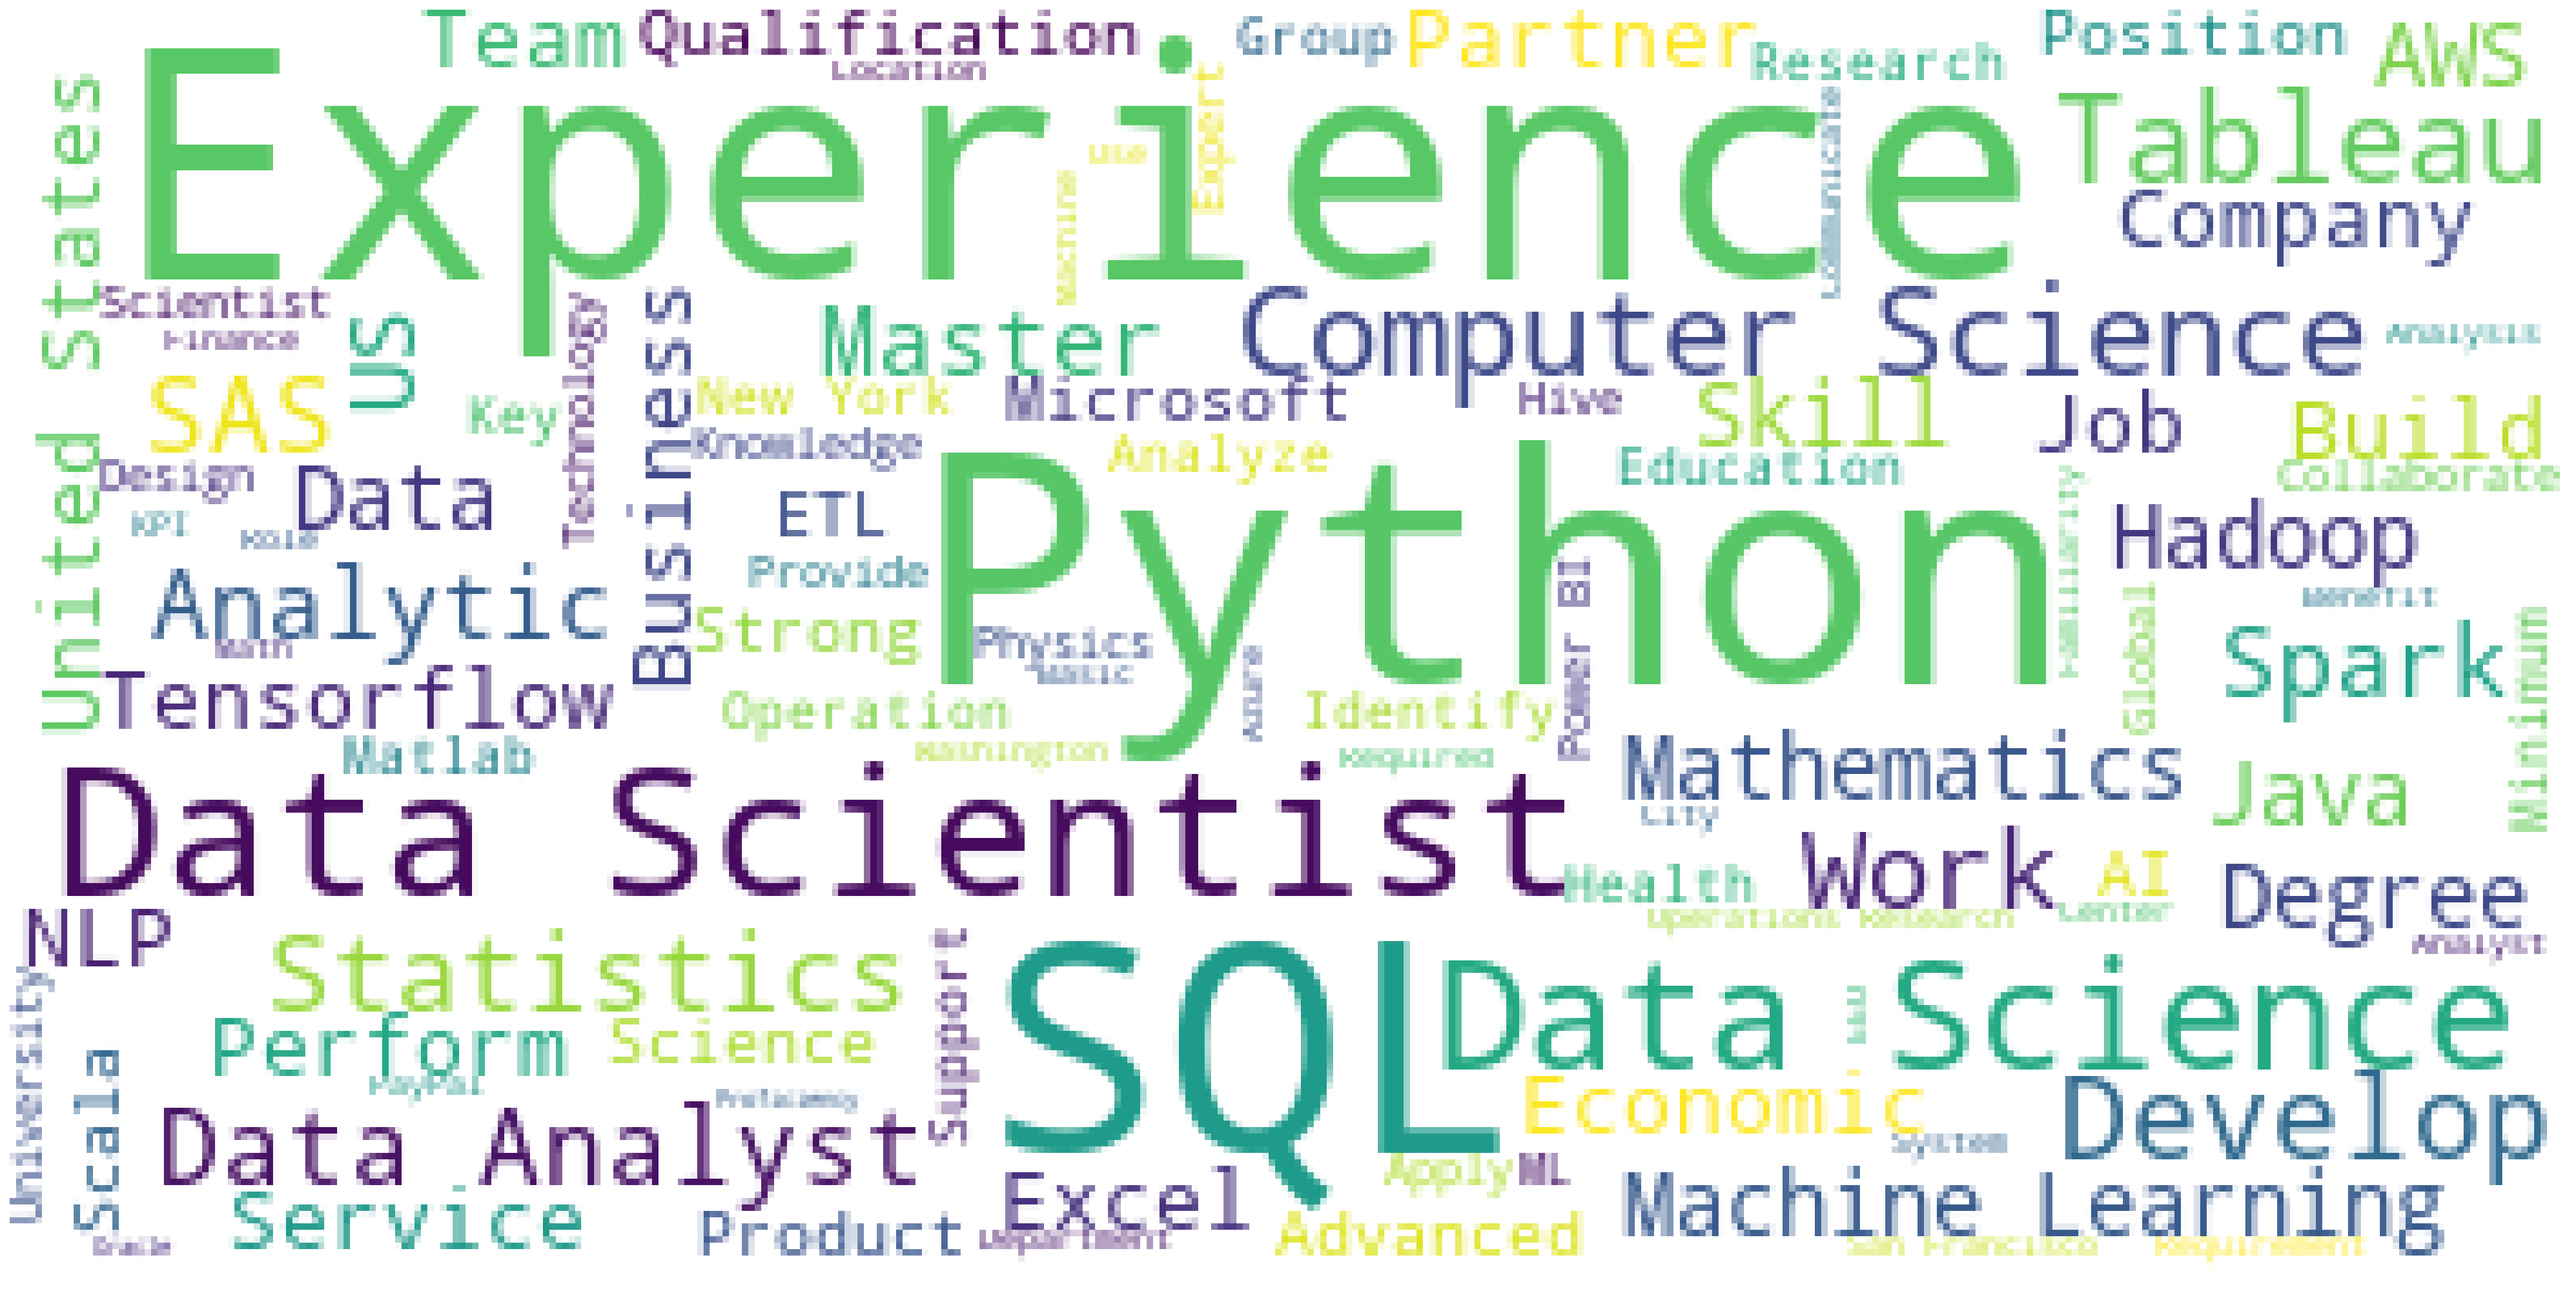

United States , data engineer :  (999, 8)
[('Python', 824), ('SQL', 759), ('Experience', 732), ('ETL', 511), ('Data Engineer', 476), ('AWS', 383), ('Computer Science', 377), ('Spark', 364), ('Hadoop', 260), ('Java', 244), ('Develop', 228), ('Work', 199), ('Data Science', 185), ('Kafka', 176), ('R', 175), ('Tableau', 173), ('Scala', 167), ('Data Scientist', 157), ('Build', 151), ('Hive', 144), ('Statistics', 138), ('NoSQL', 124), ('Redshift', 121), ('Machine Learning', 109), ('Master', 106), ('Azure', 102), ('Oracle', 100), ('Mathematics', 100), ('SAS', 100), ('BI', 90), ('Snowflake', 90), ('Degree', 88), ('SQL Server', 88), ('Identify', 85), ('U.S.', 83), ('United States', 80), ('Airflow', 78), ('Skills', 77), ('Analytics', 75), ('Business Intelligence', 74), ('US', 73), ('Familiarity', 73), ('Company', 71), ('EMR', 68), ('Position', 67), ('Collaborate', 65), ('Informatica', 64), ('Design', 63), ('APIs', 62), ('Partner', 62)]


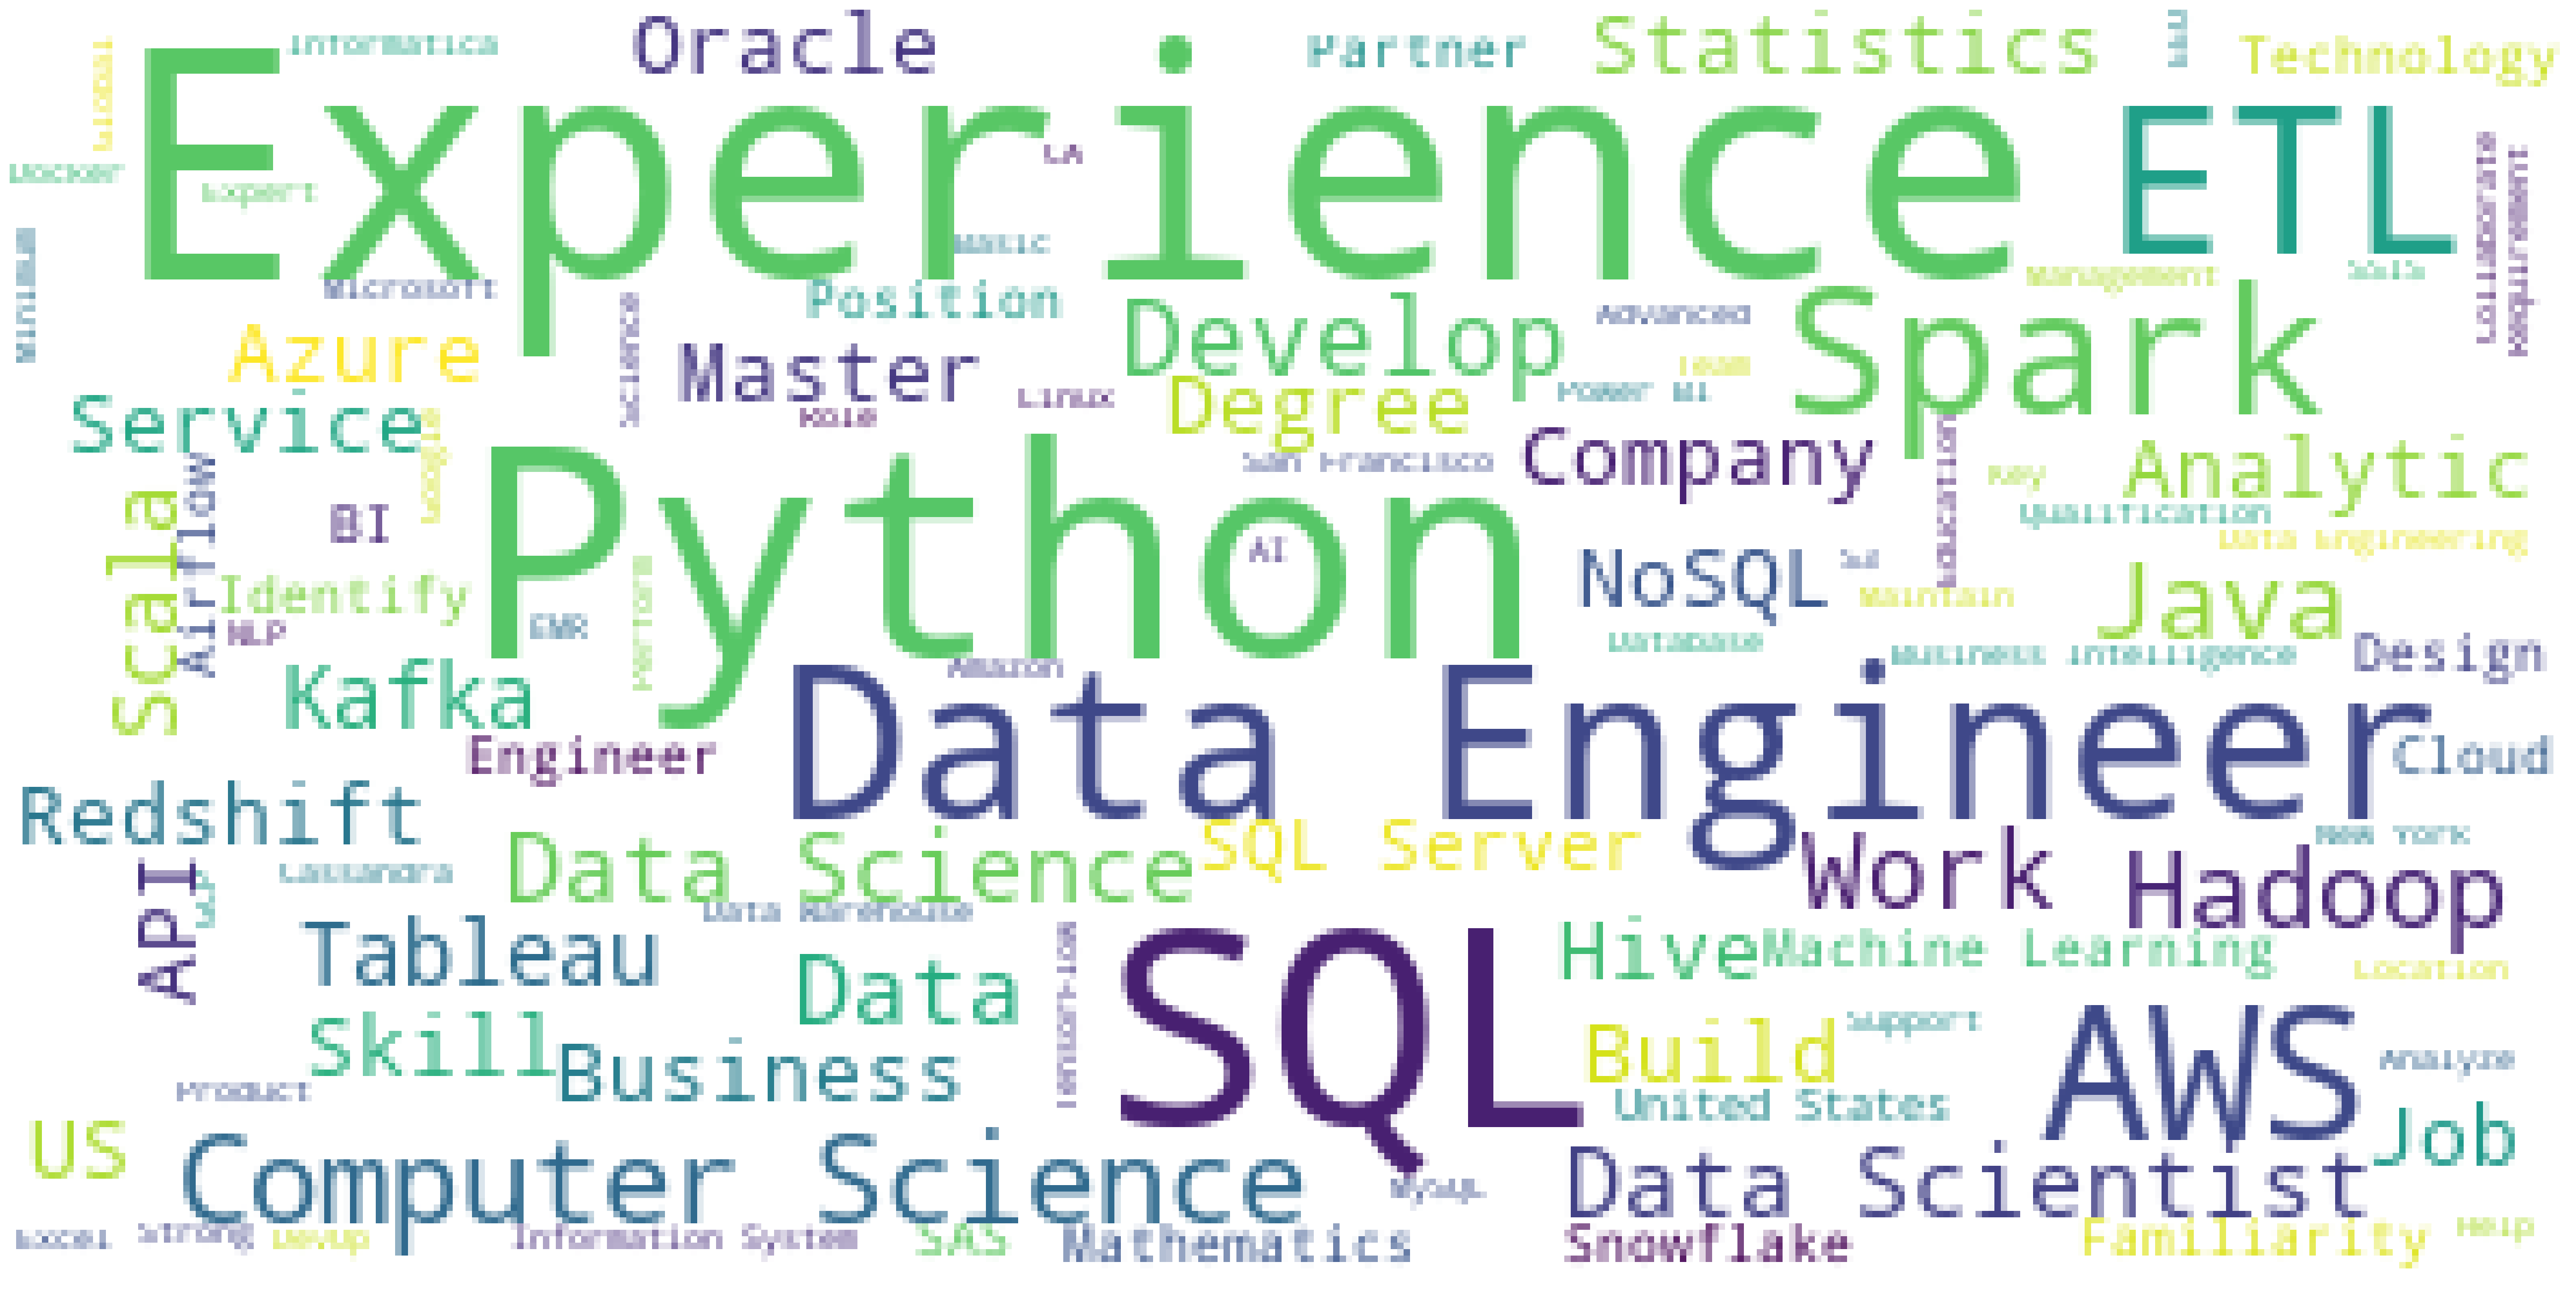

United States , data analyst :  (1000, 8)
[('SQL', 735), ('Data Analyst', 589), ('Experience', 489), ('Tableau', 415), ('Python', 359), ('Excel', 337), ('Develop', 224), ('Computer Science', 222), ('Work', 200), ('R', 176), ('SAS', 170), ('Business', 158), ('ETL', 132), ('Statistics', 132), ('Microsoft', 130), ('Mathematics', 114), ('Finance', 113), ('Skills', 111), ('Perform', 107), ('Degree', 105), ('Analytics', 104), ('Analyze', 103), ('U.S.', 102), ('PowerPoint', 101), ('Power BI', 100), ('United States', 98), ('University', 97), ('Economics', 96), ('Identify', 95), ('Position', 86), ('Support', 86), ('Business Intelligence', 85), ('Partner', 81), ('Assist', 80), ('US', 79), ('Master', 77), ('Access', 75), ('Microsoft Excel', 74), ('Company', 74), ('Maintain', 72), ('Analyst', 72), ('Looker', 71), ('KPIs', 71), ('BI', 67), ('Oracle', 67), ('Data Science', 66), ('Build', 65), ('Word', 64), ('Provide', 62), ('New York', 60)]


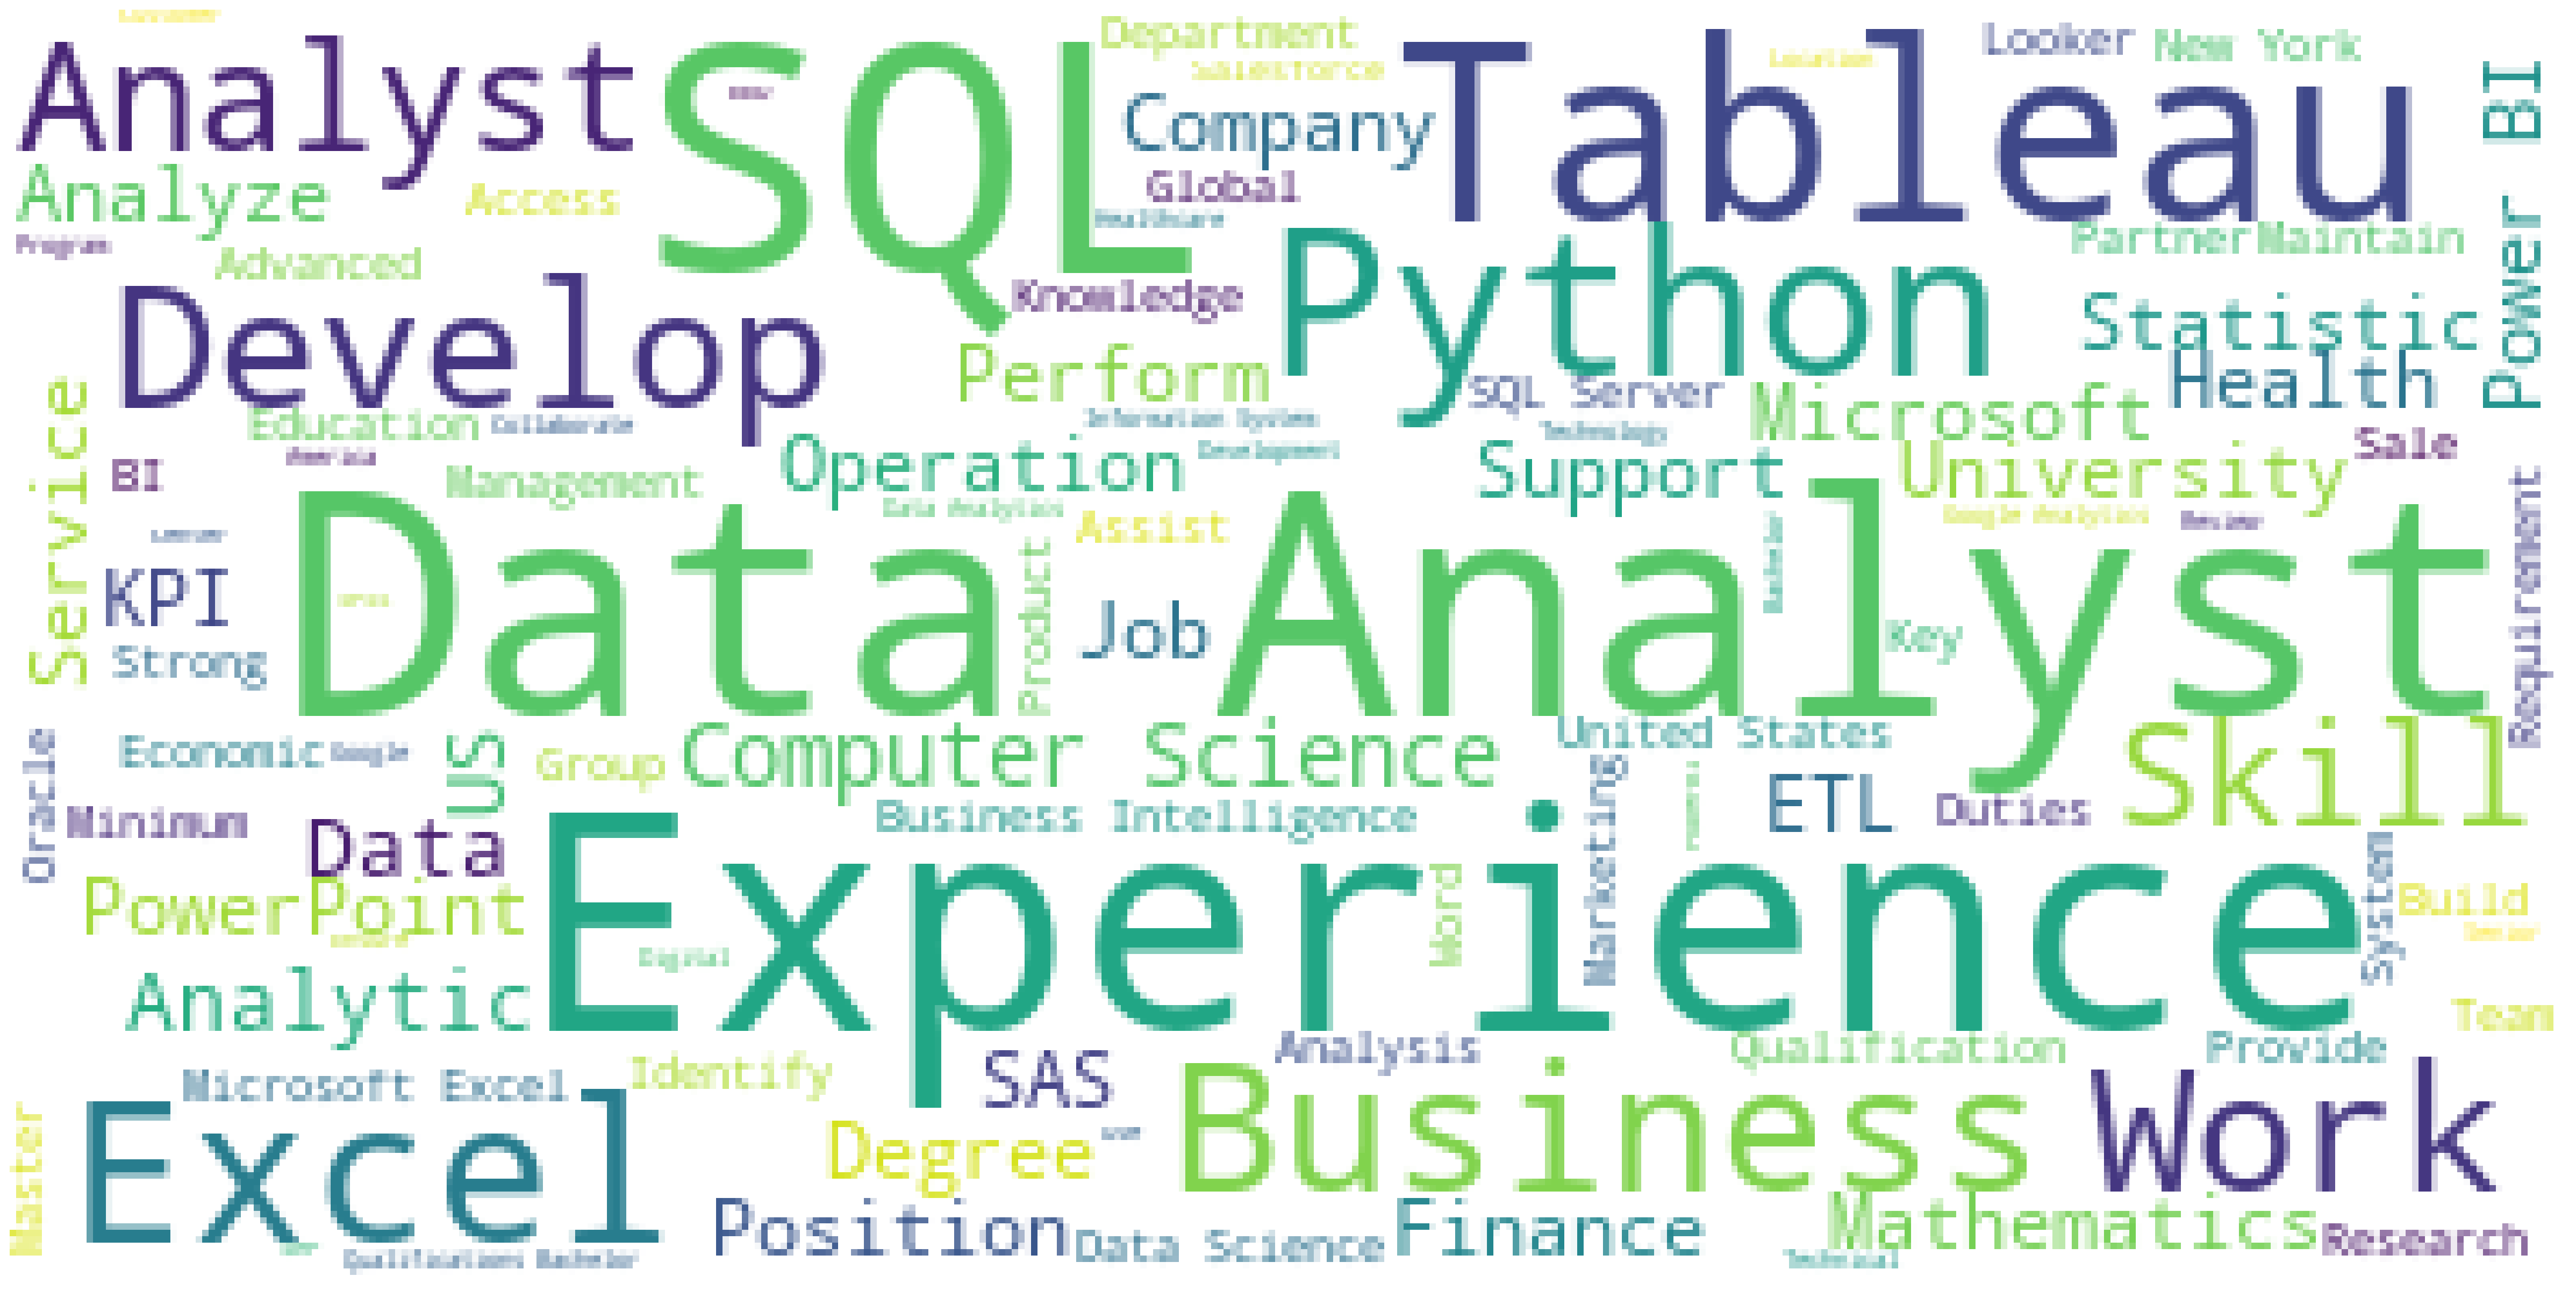

In [0]:
# df['Description'] = df['Description'].map(tokenize_description)
print("Descripion Tokenize Done.")
countries = df['Location'].unique()
titles = df['Query'].unique()
stop_words = ['Canada', 'Data', 'Strong', 'Job', 'Bachelor', 'Good', 'Engineering', 'Please', 
             'Create', 'PhD', 'Ontario', 'Ability']
entities_dt = {}
for country in countries:
    for title in titles:
        sub_df = select([country], [title])
        print(country, ',', title, ': ', sub_df.shape)
        entities_count = analyze(sub_df, 1)
        draw_cloud(entities_count)
        entities_dt[(country, title)] = entities_count
        
# for country in countries:
#     df_new = select([country], titles)
#     print(country, ': ', df_new.shape)
    
# for title in titles:
#     df_new = select(countries, [title])
#     print(title, ': ', df_new.shape)

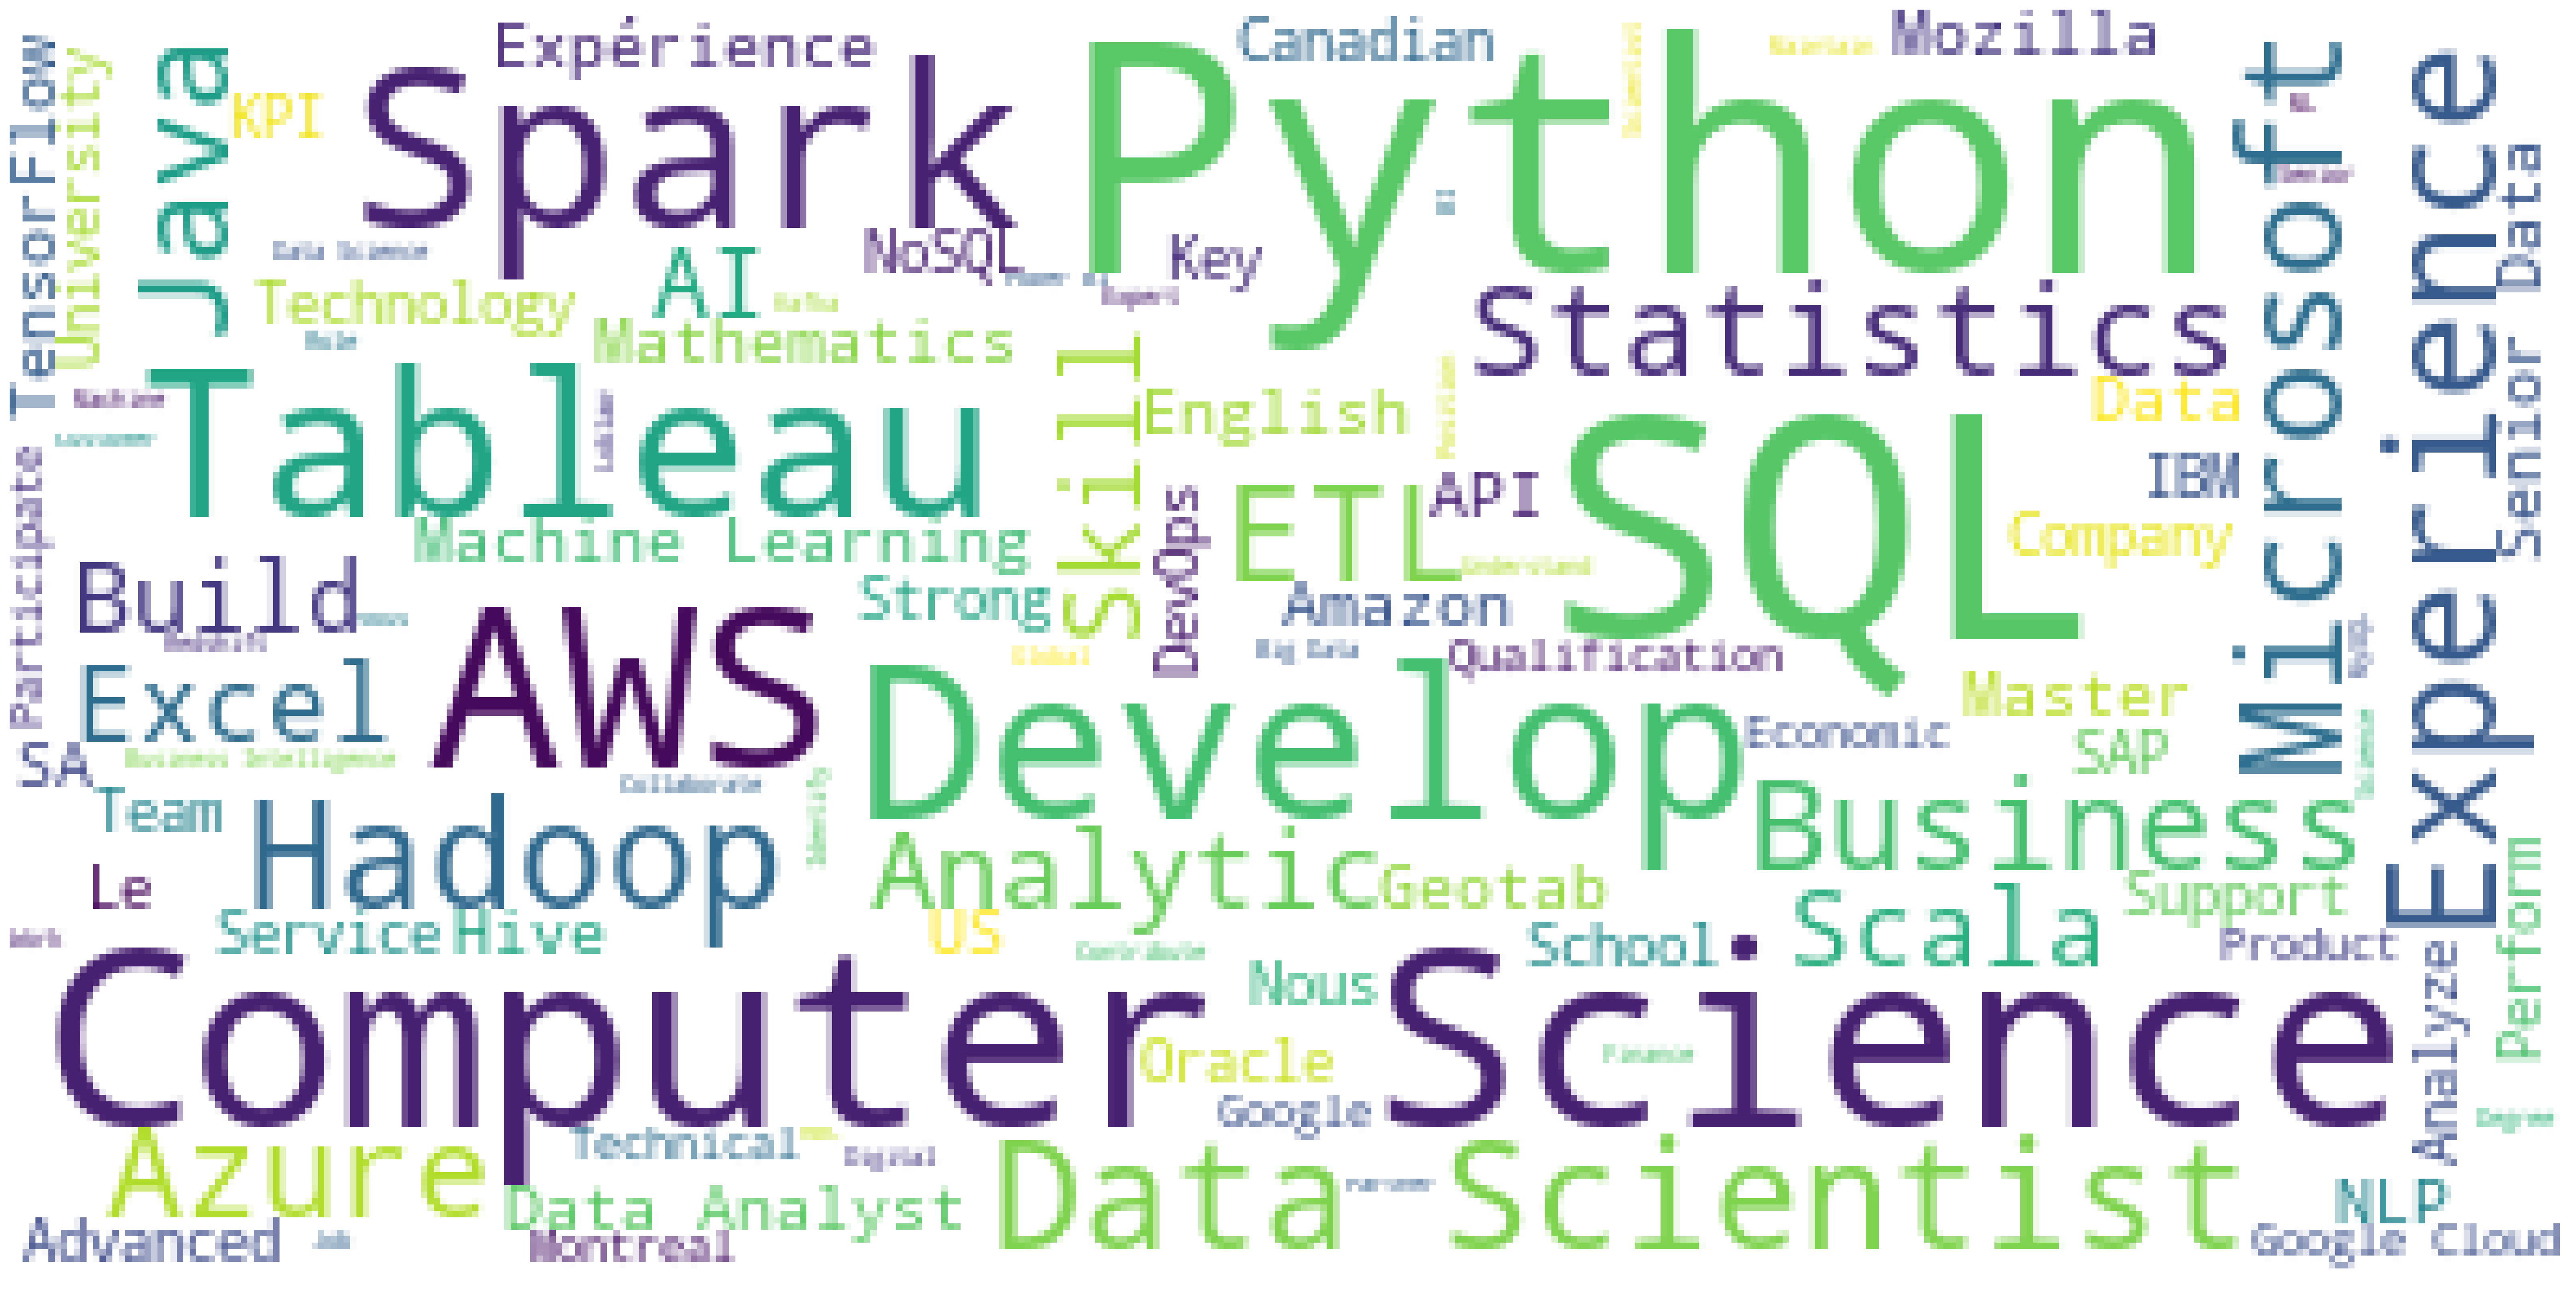

In [0]:
stop_words = ['Canada', 'Data', 'Strong', 'Job', 'Work', 'Good', 'Engineering', 'Please', 
             'Create', 'PhD', 'Ontario', 'Ability', 'Experience', 'Skill', 'Data Science', 'Data Analyst', 'Toronto']
for en in stop_words:
    if en in entities_count.keys():
        del entities_count[en]
draw_cloud(entities_count)

print('Some interesting keywords:')
keywords = ['Tableau', 'NoSQL', 'Spark', 'ETL', 'Excel', 'Hive', 'Google Cloud', 'AWS', 'Azure', 'Geotab', 'Scala',
            'NLP']

## <div id="test">Reference</div>
* https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
* https://www.nltk.org/book
* https://www.github.com/csurfer/rake-nltk

# Indeed